# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 1:

>- Juan Pablo Baudoin
>- Fran Cassinese
>- Martin Gruber
>- Mariana Abayay


# Análisis exploratorio

In [895]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
from pycountry import languages
from langid.langid import LanguageIdentifier, model

from lib.utils import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [896]:
# Estos paquetes son necesarios para el código (y no vienen instalados por defecto en Anaconda),
# descomentar los módulos que falten para instalarlos:

# !pip install emoji --upgrade --quiet
# !pip install pycountry --upgrade --quiet
# !pip install langdetect --upgrade --quiet
# !pip install pandarallel --upgrade --quiet
# !pip install langid --upgrade --quiet


## 1. Lectura de datos

In [897]:
base_name = "filtered_data_2"
src_ds = f"data/{base_name}.csv"
df_ori = pd.read_csv(src_ds)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   signal_id         13913 non-null  int64 
 1   source_posted_at  13913 non-null  object
 2   message_text      13913 non-null  object
 3   commodity         13913 non-null  object
 4   trade_type        13902 non-null  object
 5   username          8867 non-null   object
 6   title             13913 non-null  object
 7   chat_id           13913 non-null  int64 
 8   language          13913 non-null  object
dtypes: int64(2), object(7)
memory usage: 978.4+ KB


In [898]:
df_ori.rename(columns={'username':'telegram_user_id'}, inplace=True)

# Creamos una columna id con el índice de la tabla
df_ori['id_msg'] = df_ori.index


In [899]:
df_ori

,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg
0,34023,2022-05-05 12:16:04+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬S◦C°A˚L°P◦I... STORJUSD...,STORJ,buy,Scalping_300,Scalping_300%,79,es,0
1,34035,2022-07-03 01:56:33+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬S◦C°A˚L°P◦I... VETUSDT ...,VET,buy,Scalping_300,Scalping_300%,79,es,1
2,17390,2022-10-10 01:39:15+00,Pair : BTCUSDT \nLONG\nLeverage : Cross 20x\nE...,BTC,buy,CryptoCashFlowReal,Crypto Cash flow,101,es,2
3,12833,2022-10-16 19:06:39+00,🥇 #OM (Binance)\n\n🎖Buy Range : 205 - 242\n\n🎯...,OM,buy,bitcoinpumpgroup,Bitcoin Pump Group,5,es,3
4,19038,2022-10-07 05:32:36+00,🌹 #NEO/USDT\n\n🟢 LONG\n\n✅ Entry: 8.45-8.28\n\...,NEO,buy,Gtrading7,GLOBAL TRADING 🌍🌍,206,es,4
...,...,...,...,...,...,...,...,...,...,...
13908,1145165,2022-11-02 18:45:49+00,CAPTION: SHORT ⬇️\n\nSHIB1000 USDT\n\nENTRY: 0...,SHIB,buy,BybitItalian,Bybit Italiano,3745,es,13908
13909,1145214,2022-10-29 01:38:18+00,CAPTION: LONG ⬆️\n\nMKR USDT\n\nENTRY: 884.3\n...,MKR,buy,BybitItalian,Bybit Italiano,3745,es,13909
13910,1145295,2022-11-02 17:35:21+00,CAPTION: SHORT ⬇️\n\nSHIB1000 USDT\n\nENTRY: 0...,SHIB,buy,BybitItalian,Bybit Italiano,3745,es,13910
13911,1473076,2022-09-17 02:39:05+00,⚡️ #MATIC/USDT\n\n🟢 Long\n\n💠 LEVERAGE : 20x\n...,MATIC,buy,CoinExGlobalArabic,CoinEx Arabic-تداول الكريبتو بكل سهولة,4041,es,13911


In [900]:
# check if a file exists
import os
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df_ori.to_csv(work_file, index=False)
    df = df_ori.copy()
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

df.info()
# rename username column


File data/filtered_data_2_enhanced.csv already exists. Loading it.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13

In [901]:
df

,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg,date_source_posted_at,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words,message_lbr
0,135776,2022-01-10 21:34:46+00,#LTO/USDT (Binance)\n\nBuy zone: 0.3147-0.3229...,LTO,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,3472,2022-01-10 21:34:46+00:00,#lto/usdt (binance)\n\nbuy zone: 0.3147-0.3229...,ascii,#lto/usdt (binance)\nbuy zone: 0.3147-0.3229\n...,193,31,8
1,139072,2022-01-24 19:24:09+00,#UNFI/BTC (Binance)\n\nBuy zone: 17134-17585\n...,UNFI,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,1748,2022-01-24 19:24:09+00:00,#unfi/btc (binance)\n\nbuy zone: 17134-17585\n...,ascii,#unfi/btc (binance)\nbuy zone: 17134-17585\nta...,218,34,9
2,139305,2022-01-30 16:45:11+00,#NAV/BTC (Binance)\n\nBuy zone: 459-472\n\n🎯 T...,NAV,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,5960,2022-01-30 16:45:11+00:00,#nav/btc (binance)\n\nbuy zone: 459-472\n\n ta...,ascii,#nav/btc (binance)\nbuy zone: 459-472\ntarget ...,171,31,8
3,140058,2022-02-01 18:30:18+00,#AMB/BTC (Binance)\n\nBuy zone: 82-85\n\n🎯 Tar...,AMB,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,4125,2022-02-01 18:30:18+00:00,#amb/btc (binance)\n\nbuy zone: 82-85\n\n targ...,ascii,#amb/btc (binance)\nbuy zone: 82-85\ntarget 1:...,198,34,9
4,138481,2022-02-03 21:56:06+00,#BTS/BTC (Binance)\n\nBuy zone: 60-61\n\n🎯 Tar...,BTS,buy,crypto_signals_binance_pump,Crypto PUMP signals for Binance 🚀,3,es,4095,2022-02-03 21:56:06+00:00,#bts/btc (binance)\n\nbuy zone: 60-61\n\n targ...,ascii,#bts/btc (binance)\nbuy zone: 60-61\ntarget 1:...,196,34,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13908,1144890,2022-11-06 20:54:53+00,CAPTION: SHORT ⬇️\n\nADA USDT\n\nENTRY: 0.4237...,ADA,buy,BybitItalian,Bybit Italiano,3745,es,13847,2022-11-06 20:54:53+00:00,caption: short \n\nada usdt\n\nentry: 0.4237\n...,ascii,caption: short\nada usdt\nentry: 0.4237\ntp 1:...,75,15,5
13909,1301876,2022-05-09 15:08:20+00,I GOT MORE TO UPDATE BUT IMA FINISHED THE UPDA...,SAND,buy,NaN,Glass Ceiling🏴‍☠️⌨️,3846,es,13747,2022-05-09 15:08:20+00:00,i got more to update but ima finished the upda...,ascii,i got more to update but ima finished the upda...,305,65,0
13910,1350457,2022-09-29 14:58:30+00,"Bitcoin target 20500-21000, Ethereum target 14...",BITCOIN,sell,avalanche_zh,Avalanche(AVAX)官方中文群,3872,es,13703,2022-09-29 14:58:30+00:00,"bitcoin target 20500-21000, ethereum target 14...",ascii,"bitcoin target 20500-21000, ethereum target 14...",53,6,0
13911,1473446,2022-03-29 17:09:11+00,CAPTION: Currency: \n#uma\nEntry: $7.95\nTarge...,UMA,buy,CoinExGlobalArabic,CoinEx Arabic-تداول الكريبتو بكل سهولة,4041,es,13912,2022-03-29 17:09:11+00:00,caption: currency: \n#uma\nentry: $7.95\ntarge...,ascii,caption: currency:\n#uma\nentry: $7.95\ntarget...,91,13,4


## 2. Análisis de datos categóricos y texto
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categóricas: commodity, trade_type, chat_id, telegram_user_id
- Análisis del campo message_text: mediante una inspección de datos muestral se ve que existen varios idiomas, que se tienen múltiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el análisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



In [902]:
# group df by id and count the number of rows
df_grouped_id = df.groupby('signal_id').size().reset_index(name='counts')
# sort the values by counts
df_grouped_id = df_grouped_id.sort_values(by='counts', ascending=False)
df_grouped_id

,signal_id,counts
0,10,1
9280,184952,1
9269,184919,1
9270,184922,1
9271,184924,1
...,...,...
4641,59057,1
4642,59067,1
4643,59074,1
4644,59085,1


### 2.1 Nulos

In [903]:
# get the percentage of missing values in the dataset
missing_values = df_ori.isnull().mean() * 100
# sort the columns by the percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columns with missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columns with no missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")

############
Columns with missing values
    telegram_user_id: 36.27%
    trade_type: 0.08%
############
Columns with no missing values
    signal_id
    source_posted_at
    message_text
    commodity
    title
    chat_id
    language
    id_msg


In [904]:
# Excluir los registros sin chat_id
df = df.dropna(subset=['chat_id'])
df = df.dropna(subset=['message_text'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13913 non-null  datetime64[ns, UTC]
 11  message_text_clean       139

## Filtado de mensajes en ingles

In [905]:
# List the languages in the datase language column
languages = df['language'].unique()
print(languages)


['es']


In [906]:
# filter the messages with language 'en'
# flt_en = df['language'] == 'en'
flt_en = df['language'] == 'es'
df = df[flt_en]

print(f"Numero de mensajes en ingles: {df.shape[0]}")

Numero de mensajes en ingles: 13913


### 2.2. Frecuencias simples

#### 2.2.1. Top 10 de conteos

In [907]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - BTC: 557 	 (4.0% - 4.00%)
02 - ETH: 388 	 (2.79% - 6.79%)
03 - LTC: 235 	 (1.69% - 8.48%)
04 - BNB: 218 	 (1.57% - 10.05%)
05 - DYDX: 214 	 (1.54% - 11.59%)
06 - TRX: 213 	 (1.53% - 13.12%)
07 - GALA: 194 	 (1.39% - 14.51%)
08 - AXS: 181 	 (1.3% - 15.81%)
09 - YFI: 173 	 (1.24% - 17.05%)
10 - MATIC: 163 	 (1.17% - 18.22%)
11 - MASK: 162 	 (1.16% - 19.38%)
--------
Top 11 Canal (chat_id):
01 - 79: 2599 	 (18.68% - 18.68%)
02 - 169: 2409 	 (17.31% - 35.99%)
03 - 101: 1427 	 (10.26% - 46.25%)
04 - 5: 1134 	 (8.15% - 54.40%)
05 - 180: 870 	 (6.25% - 60.65%)
06 - 71: 723 	 (5.2% - 65.85%)
07 - 2131: 440 	 (3.16% - 69.01%)
08 - 78: 416 	 (2.99% - 72.00%)
09 - 66: 378 	 (2.72% - 74.72%)
10 - 206: 290 	 (2.08% - 76.80%)
11 - 2269: 283 	 (2.03% - 78.83%)
--------
Top 11 Users (telegram_user_id):
01 - N/A: 5046 	 (36.27%  - 36.27%) 	 (NaN)
02 - Scalping_300: 2599 	 (18.68%  - 54.95%) 	 (W/NaN 29.31% - 29.31%)
03 - CryptoCashFlowReal: 1427 	 (10.26%  - 65.21%) 	 

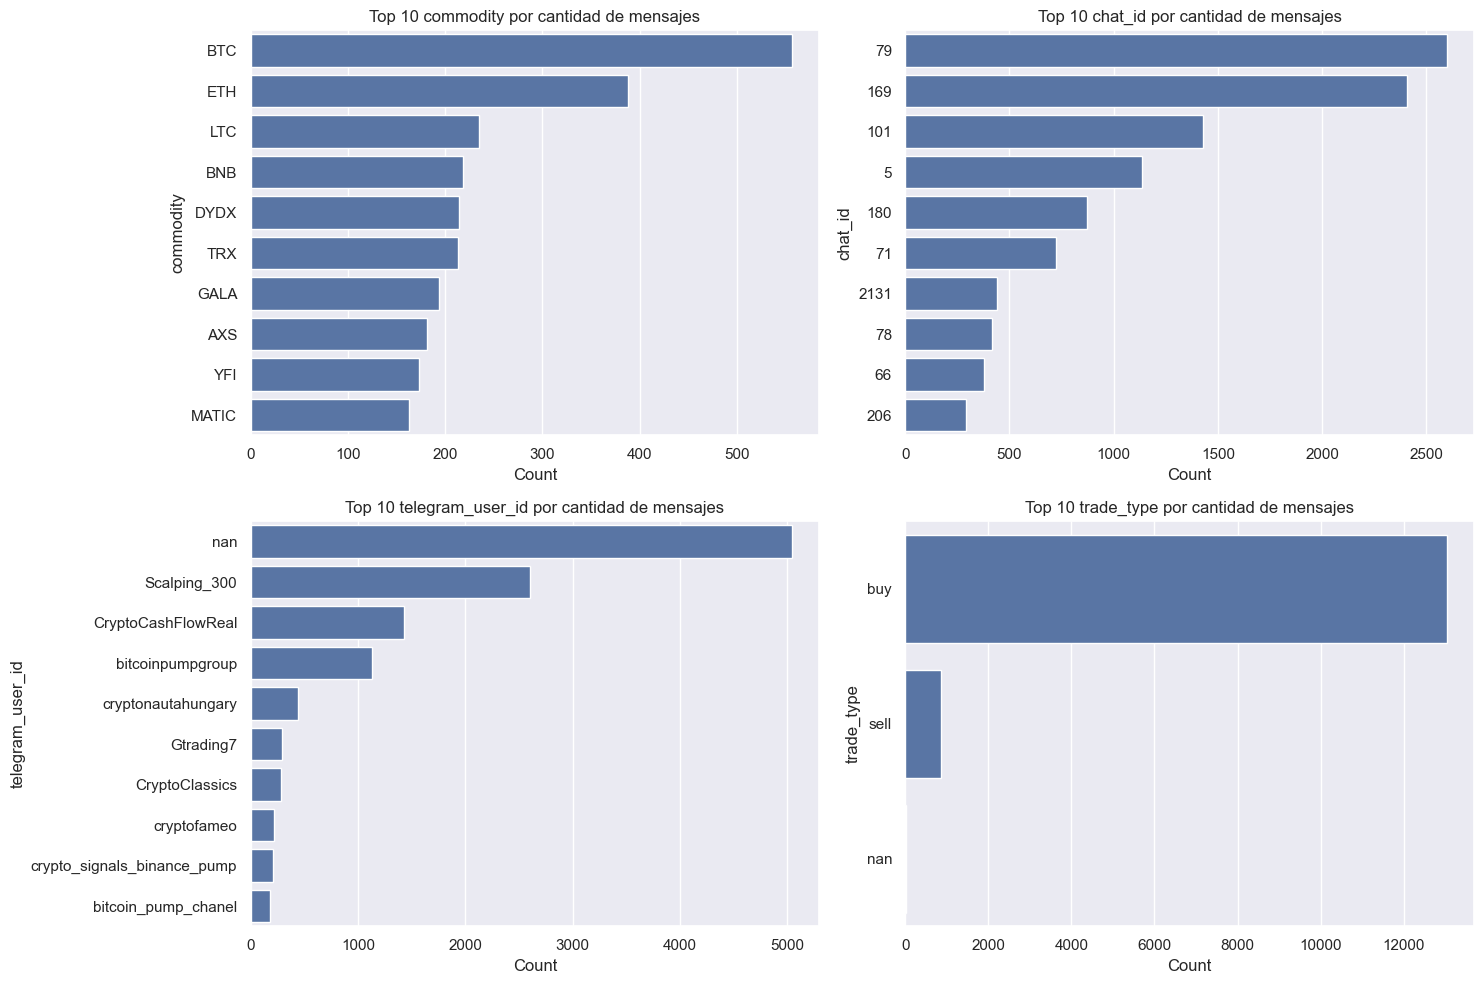

In [908]:
columns_to_plot = ['commodity', 'chat_id', 'telegram_user_id', 'trade_type']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    value_counts = df[column].astype(str).value_counts(dropna=False).head(10)
    
    # Convert value_counts to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    # Create the barplot
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 {column} por cantidad de mensajes')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2.2.2. Cruce de variables `telegram_user_id` y `chat_id`

In [909]:
# count the number of chat_ids
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

# count the number of users
users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")



Number of chat_ids: 128
Number of users: 110


In [910]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()} ({single_user_chats.count()/chat_ids:.2%})")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()} ({single_chat_users.count()/users:.2%})")


# Distribucion de numero de mensajes por canal


Number of chats with a single user: 110 (85.94%)
Number of users with a single chat: 110 (100.00%)


In [911]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 0
Number of chats with more than one user: 0.00%
Series([], Name: telegram_user_id, dtype: int64)
--------
Number of users with more than one chat: 0
Number of users with more than one chat: 0.00%
Series([], Name: chat_id, dtype: int64)


### 2.3. Análisis del campo message_text
#### 2.3.1. Limpieza de datos y enriquecimiento simple

Para continuar con el análisis exploratorio, como indicamos antes, necesitamos realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo
    - Clean emojis: Remover los emojis
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8


In [912]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break

    # df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply
    # (lambda x: '\n'.join(line.strip() for line in x.splitlines() if line.strip()))

    try:
        cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    except Exception as e:
        print(text, type(text))
        print(e)
        cleaned_text = text
        raise e
    return cleaned_text
    

In [913]:
force_process = False

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################

    # Eliminar emojis y añadir columna message_no_emoji
    print("Cleaning Emojis")
    df['message_text_clean'] = df['message_text'].parallel_apply(remove_emojis).str.strip().str.lower()

    # # Detect the encoding of messages in the field message_text_clean of type string\
    print("Detecting encoding")
    df['message_encoding'] = df['message_text_clean'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Limpieza sobre el encoding utf8 ###
    #######################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    print("Convert to utf-8")
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    # print("Detecting encoding on new utf-8 messages")
    # df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Trim and remove multiple line breaks
    print("Cleaning LBR")
    df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply(clean_lbr)

    # Añadir columna con la longitud del mensaje sin emojis
    print("Checking message length")
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    print("Checking message words")
    df['message_words'] = df['message_text_clean_utf8'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df['message_lbr'] = df['message_text_clean_utf8'].parallel_apply(count_line_breaks)

    print("Store the processed data")
    df.to_csv(work_file, index=False)


In [914]:
# find messages with a length of 0
zero_length = df['message_length'] == 0
print(f"Number of messages with a length of 0: {zero_length.sum()}")

# drop messages with a length of 0
df = df[~zero_length]
df.to_csv(work_file, index=False)


Number of messages with a length of 0: 0


#### 2.3.3. Mensajes duplicados

In [915]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 7341
Percentage of duplicated messages: 52.76%
--------


In [916]:
duplicated_messages.head(5)['id_msg']

595      4720
600      6022
8809     2428
8810     8611
8987    12850
Name: id_msg, dtype: int64

In [917]:
df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13913 non-null  datetime64[ns, UTC]
 11  message_text_clean       139

In [918]:
# repeated_window
repeated_window = 1 # Window where to consider repeated messages within the same chat_id a repeated messaged

df = df.sort_values(by=['chat_id', 'message_text_clean_utf8', 'date_source_posted_at'])

# Group by chat_id and find the time difference between consecutive messages
# df['time_diff'] = df.groupby('chat_id', 'message_text_clean_utf8')['date_source_posted_at'].diff()
df['time_diff'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['date_source_posted_at'].diff()


# Mark duplicates as those with a time difference less than 5 minutes (300 seconds) and the same message text
df['duplicates'] = df['message_text_clean_utf8'].duplicated(keep=False)
df['duplicate_count'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['id_msg'].transform('count')
df['duplicates_near'] = (df['time_diff'] <= pd.Timedelta(minutes=repeated_window)) & (df['message_text_clean_utf8'].duplicated(keep='first'))




cols_check = ['chat_id', 'date_source_posted_at', 'message_text_clean_utf8', 'time_diff', 'duplicates', 'duplicates_near', 'duplicate_count']
df[cols_check].sort_values(by=['chat_id', 'date_source_posted_at']).head(10)

# Keep only the first message in the case of duplicates
# df_filtered = df[~df['duplicate']]

# Drop helper columns if not needed
# df_filtered = df_filtered.drop(columns=['time_diff', 'duplicate'])

# count the number of duplicates_near
duplicates_near = df['duplicates_near'].sum()
print(f"Number of duplicates_near: {duplicates_near}")
print(f"Percentage of duplicates_near: {duplicates_near/df.shape[0]:.2%}")


Number of duplicates_near: 3385
Percentage of duplicates_near: 24.33%


#### 2.3.4. Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

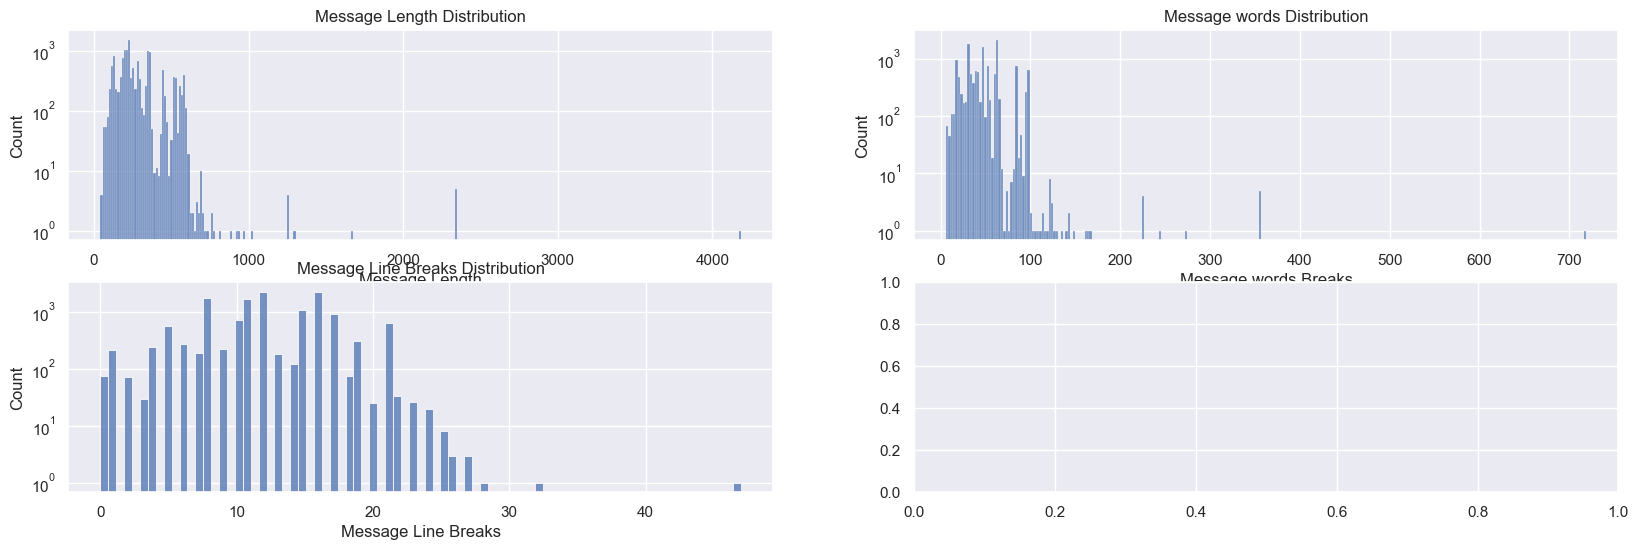

In [919]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado. Vemos que existen outliers en todas las distribuciones, los cuales podríamos analizar en más detalle.

In [920]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,13913.000000,13913.000000,13913.000000
mean,288.246891,48.744484,12.235391
std,146.104835,24.170762,4.572369
min,42.000000,6.000000,0.000000
25%,195.000000,32.000000,9.000000
50%,239.000000,46.000000,12.000000
75%,360.000000,64.000000,16.000000
max,4185.000000,719.000000,47.000000


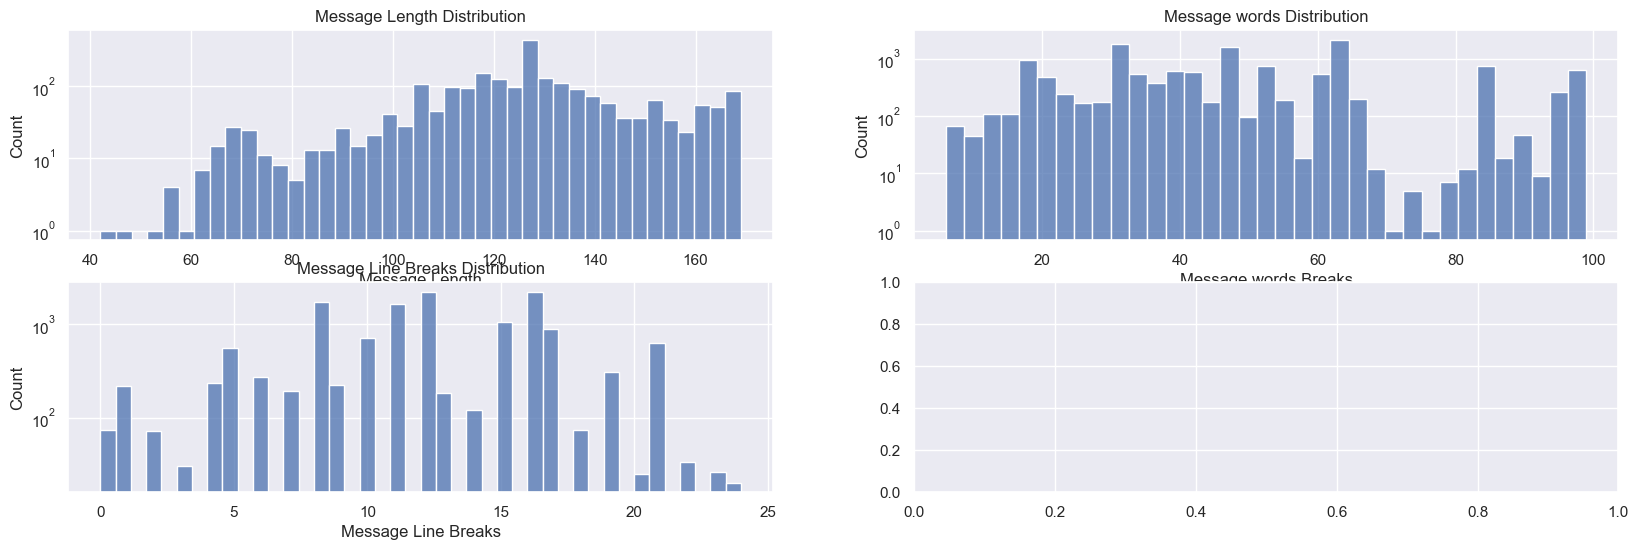

In [921]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

flt_mbr = (df['message_lbr'] < 25) & (df['message_lbr'] >= 0) 
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

In [922]:
print_top(df, 'message_lbr', "LBR", top=21)

Top 21 LBR (message_lbr):
01 - 12: 2244 	 (16.13% - 16.13%)
02 - 16: 2233 	 (16.05% - 32.18%)
03 - 8: 1763 	 (12.67% - 44.85%)
04 - 11: 1671 	 (12.01% - 56.86%)
05 - 15: 1073 	 (7.71% - 64.57%)
06 - 17: 902 	 (6.48% - 71.05%)
07 - 10: 713 	 (5.12% - 76.17%)
08 - 21: 637 	 (4.58% - 80.75%)
09 - 5: 559 	 (4.02% - 84.77%)
10 - 19: 308 	 (2.21% - 86.98%)
11 - 6: 270 	 (1.94% - 88.92%)
12 - 4: 237 	 (1.7% - 90.62%)
13 - 9: 222 	 (1.6% - 92.22%)
14 - 1: 217 	 (1.56% - 93.78%)
15 - 7: 192 	 (1.38% - 95.16%)
16 - 13: 182 	 (1.31% - 96.47%)
17 - 14: 120 	 (0.86% - 97.33%)
18 - 0: 74 	 (0.53% - 97.86%)
19 - 18: 74 	 (0.53% - 98.39%)
20 - 2: 71 	 (0.51% - 98.90%)
21 - 22: 33 	 (0.24% - 99.14%)


In [923]:
print_top(df, 'message_words', "Words", top=80)

Top 80 Words (message_words):
01 - 64: 2157 	 (15.5% - 15.50%)
02 - 46: 1522 	 (10.94% - 26.44%)
03 - 32: 1198 	 (8.61% - 35.05%)
04 - 85: 750 	 (5.39% - 40.44%)
05 - 52: 740 	 (5.32% - 45.76%)
06 - 98: 626 	 (4.5% - 50.26%)
07 - 19: 554 	 (3.98% - 54.24%)
08 - 61: 547 	 (3.93% - 58.17%)
09 - 38: 482 	 (3.46% - 61.63%)
10 - 42: 352 	 (2.53% - 64.16%)
11 - 31: 338 	 (2.43% - 66.59%)
12 - 30: 286 	 (2.06% - 68.65%)
13 - 36: 276 	 (1.98% - 70.63%)
14 - 21: 273 	 (1.96% - 72.59%)
15 - 95: 254 	 (1.83% - 74.42%)
16 - 33: 248 	 (1.78% - 76.20%)
17 - 17: 221 	 (1.59% - 77.79%)
18 - 20: 212 	 (1.52% - 79.31%)
19 - 66: 193 	 (1.39% - 80.70%)
20 - 18: 176 	 (1.27% - 81.97%)
21 - 54: 172 	 (1.24% - 83.21%)
22 - 41: 148 	 (1.06% - 84.27%)
23 - 34: 147 	 (1.06% - 85.33%)
24 - 35: 143 	 (1.03% - 86.36%)
25 - 23: 125 	 (0.9% - 87.26%)
26 - 29: 111 	 (0.8% - 88.06%)
27 - 37: 106 	 (0.76% - 88.82%)
28 - 44: 105 	 (0.75% - 89.57%)
29 - 43: 101 	 (0.73% - 90.30%)
30 - 39: 92 	 (0.66% - 90.96%)
31 - 12: 9

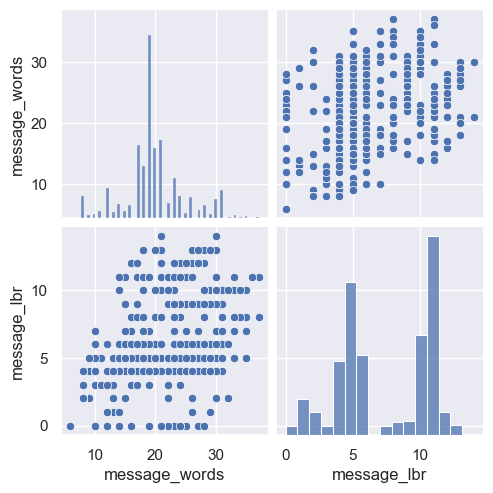

In [924]:
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_words', 'message_lbr']])
plt.show()

## 3. Análisis en series de tiempo

# Similarities

In [925]:
sim_work_file = f"data/{base_name}_enhanced_sim.csv"
if os.path.exists(sim_work_file):
    print(f"File {sim_work_file} already exists. Loading it.")
    df_sim = pd.read_csv(sim_work_file)
    df_sim['date_source_posted_at'] = pd.to_datetime(df_sim['date_source_posted_at'])
else:
    df_sim = df.copy()
    df_sim.rename(columns={'message_lbr': 'message_lbr_utf8'}, inplace=True)
    df_sim.rename(columns={'message_words': 'message_words_utf8'}, inplace=True)

df_sim.info()

File data/filtered_data_2_enhanced_sim.csv already exists. Loading it.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at  

## additional cleanup

In [926]:
# Instalación de las bibliotecas necesarias
import os
import nltk
import spacy
import pandas as pd
import re
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [927]:
def create_word_bins(df, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                               10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                               20, 21, 22, 23, 24, 25, 26, 27, 28, 29, np.inf]):
    """
    Function to bin the word count into categories.
    You can modify 'bins' based on your use case.
    """
    # Create a new column 'word_bin' based on the number of words
    df['word_bin'] = pd.cut(df['message_words'], bins=bins, labels=False, right=False)
    return df

In [928]:
from dateutil.parser import parse

def is_date(string): # NEEDS MORE WORK
    try:
        # Try to parse the string as a date
        parse(string, fuzzy=False)
        return True
    except ValueError:
        return False
    except Exception as e:
        print(f"Error checking date with: {string}")
        print(e)
        return False

def is_number(string):
    try:
        float(string)  # Try to convert to float
        return True
    except ValueError:
        return False
    except Exception as e:
        print(f"Error checking number with: {string}")
        print(e)
        return False


stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess(text, stop_words=stop_words):

    text = text.lower()
    # tokenizar el texto
    text = text.replace('\n', ' LBRMARK ')

    
    text_tokens = word_tokenize(text)
    # replace numbers with a placeholder
    # print(text_tokens)
    text_tokens_rst = text_tokens.copy() 
    i = -1
    for token in text_tokens:
        i += 1
        token = re.sub(r'\s+', ' ', token)

        # if token in stop_words:
        #     # remove the token from the list
        #     text_tokens_rst.pop(i)
        #     i -= 1
        #     # text_tokens_rst[i] = '{STOP_WORD}'
        #     continue

        if is_number(token):
            text_tokens_rst[i] = '{NUM}'
            continue

        if is_date(token):
            text_tokens_rst[i] = '{DATE}'
            continue

        tmp_token = re.sub(r'[^a-zA-Z0-9@\s]', ' ', token)  # eliminar caracteres especiales
        if tmp_token == token:
            continue
        text_tokens_rst[i] = preprocess(tmp_token)

    text = ' '.join(text_tokens_rst)
    # print(text)

    # text = re.sub(r'[^a-zA-Z0-9@\s]', ' ', text)  # eliminar caracteres especiales
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # print(text)

    text = text.replace(' LBRMARK ', '\n')
    text = text.replace('LBRMARK', '\n')
    text = clean_lbr(text)
    return text


# df['tokenized_nltk'] = df['cleaned'].apply(word_tokenize)

# aclarar que se usa un dataset expandido
# Evolucion temporal con los meses con más mensajes
# conteo de users y chat_ids
# Mensajes por tipo de operación




In [929]:
force_process = True
# sim_work_file = f"data/{base_name}_enhanced_sim.csv"
if 'cleaned_sim' not in df_sim.columns or force_process :
    print("Cleaning messages")
    # # apply preprocess to the messages df_sim['message_text_clean_utf8']
    df_sim['cleaned_sim'] = df_sim['message_text_clean_utf8'].apply(preprocess)

    # Añadir columna con el número de palabras
    print("Checking message words")
    df_sim['message_words'] = df_sim['cleaned_sim'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df_sim['message_lbr'] = df_sim['cleaned_sim'].parallel_apply(count_line_breaks)

    print("Creating word bins")
    df_sim = create_word_bins(df_sim)

    print("Store the processed data")
    df_sim.to_csv(sim_work_file, index=False)


Cleaning messages
Checking message words
Checking message LBRs
Creating word bins
Store the processed data


In [930]:
df_sim.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13913 non-null  datetime64[ns, UTC]
 11  message_text_clean       139

## Groups to analize

Vamos a revisar los mensajes por grupos que compartan message_lbr', 'word_bin y trade_type

In [931]:
def gen_groups(df_msg):
# def gen_groups(df, group_cols):
    df_grouped = None
    print("Grouping")
    # df_grouped = df_sim.groupby([group_cols], dropna=False)
    df_grouped = df_msg.groupby(['message_lbr', 'word_bin', 'trade_type'], dropna=False)
    # transform the groupby object to a DataFrame
    df_grouped = df_grouped.size().reset_index(name='count')


    # replace NA values in commodity  wiht {Not Specified}
    df_grouped['trade_type'] = df_grouped['trade_type'].fillna('{Not Specified}')

    # sort df_grouped by count
    df_grouped = df_grouped.sort_values(by='count', ascending=False)

    return df_grouped

df_grouped = gen_groups(df_sim)

# print df_grouped size
print(f"Number of rows in df_grouped: {df_grouped.shape[0]}")

grp_min_size = 10
flt = df_grouped['count'] > grp_min_size
df_grouped2 = df_grouped[flt]

print(f"Number of rows in df_grouped filter by size > {grp_min_size}: {df_grouped2.shape[0]}")


Grouping
Number of rows in df_grouped: 230
Number of rows in df_grouped filter by size > 10: 68


In [932]:
df_grouped2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 205 to 154
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   message_lbr  68 non-null     int64 
 1   word_bin     68 non-null     int64 
 2   trade_type   68 non-null     object
 3   count        68 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.7+ KB


In [933]:
df_grouped2

,message_lbr,word_bin,trade_type,count
205,16,29,buy,2194
193,12,29,buy,2015
145,8,29,buy,1338
184,11,29,buy,1172
201,14,29,buy,950
...,...,...,...,...
15,0,29,buy,13
20,1,22,buy,13
21,1,22,sell,12
159,9,29,sell,12


## Compare list

Para determinar que mensajes vamos a comparar, vamos a procesarlos por una ventana de tiempo, en la que un mesaje se comparara con los otros de su grupo dentro de esa ventana. La ventana se define con el inicio del mensaje a comparar y un tamaño de ventana en días.

Por ejemplo si la ventana es de 7 días se compararia un mensaje con los que esten dentro de los siguientes 7 días a partir de la fecha del mensaje, esto dentro del grupo al que el mensaje pertenece.


In [934]:
# buid compare list per groups

def build_compare_list(df_grouped, window_size, df_sim):
    # loop over df_grouped
    results = []
    ctrl_duplicated = {}
    tokenization = {}
    # msg_fld = 'message_text_clean_utf8'
    # window_size = 7

    # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # mdl = BertModel.from_pretrained('bert-base-uncased')

    # for idx, row in df_grouped2.head(1).iterrows():
    for idx, row in df_grouped.iterrows():
        # print the row

        message_lbr = row['message_lbr']
        word_bin = row['word_bin']
        trade_type = row['trade_type']
        count = row['count']

        
        
        

        print(f"message_lbr: {message_lbr}, word_bin: {word_bin}, trade_type: {trade_type}, count: {count}")

        # filter df by message_lbr, word_bin and commodity 
        if trade_type == '{Not Specified}':
            flt = (df_sim['message_lbr'] == message_lbr) & (df_sim['word_bin'] == word_bin) & df_sim['trade_type'].isnull()
        else:
            flt = (df_sim['message_lbr'] == message_lbr) & (df_sim['word_bin'] == word_bin) & (df_sim['trade_type'] == trade_type)
        
        # also filter by chat_id not in the group
        
        grp_src = df_sim[flt][['id_msg', 'chat_id', 'date_source_posted_at']].sort_values(by='date_source_posted_at')
        
        
        chk = [12058, 11994, 12068, 12070, 12072, 12077 ]
        # loop over grp_src
        for idx_src, row2 in grp_src.iterrows():
            # print the row
            id_src = row2['id_msg']
            chat_id = row2['chat_id']
            date_source_posted_at_src= row2['date_source_posted_at']
            # print(f"    id: {idx_src}, date_source_posted_at: {date_source_posted_at_src}")
            # define the slinding window
            window_start = date_source_posted_at_src
            window_end = window_start + pd.Timedelta(days=window_size)
            
            sliding_window_flt = (grp_src['date_source_posted_at'] >= window_start) &  (grp_src['date_source_posted_at'] <= window_end)
            sliding_window_flt = sliding_window_flt & (grp_src['chat_id'] != chat_id)
            
            # Select all rows in the same sub-group that are within the 7-day window
            df_sliding_window = grp_src[sliding_window_flt]
            # print the number of rows in the sliding window
            # print(f"        Number of rows in the sliding window: {df_sliding_window.shape[0]}")
            # Iterate ove the sliding window to print the id and date_source_posted_at

            for idx_comp, row3 in df_sliding_window.iterrows():
                id_comp= row3['id_msg']
                # if is the record itself, skip
                if id_src == id_comp:
                    # tokenization[id_src] =  get_bert_embedding(row3[msg_fld], tokenizer, mdl)
                    continue
                # if we already processed this comparison, skip
                if id_comp in ctrl_duplicated and id_src in ctrl_duplicated[id_comp]:
                    continue
                
                # if id_comp not in tokenization:
                #     tokenization[id_comp] =  get_bert_embedding(row3[msg_fld], tokenizer, mdl)
                # similarity = cosine(tokenization[id_src], tokenization[id_comp])
                if id_src in ctrl_duplicated:
                    ctrl_duplicated[id_src][id_comp] = 1
                else:
                    ctrl_duplicated[id_src] = {id_comp: 1}
                date_source_posted_at_comp= row3['date_source_posted_at']
                # print(f"            id_src: {id_src}, date_source_posted_at: {date_source_posted_at}")
                # print(f"            id_comp: {id_comp}, date_source_posted_at: {date_source_posted_at_comp}")
                # print("---------")
                dict_row = {
                    'message_lbr': message_lbr,
                    'word_bin': word_bin,
                    'trade_type': trade_type,
                    'id_1': id_src,
                    'id_2': id_comp,
                    'date_id_1': date_source_posted_at_src,
                    'date_id_2': date_source_posted_at_comp,
                    # 'similarity': similarity,
                    # 'distance': 1 - similarity
                    }
                if id_src in chk:
                    print('###########')
                    print(f"    lbr: {message_lbr}")
                    print(f"    word_bin: {word_bin}")
                    print(f"    trade_type: {trade_type}")
                    print('-----')
                    print(dict_row)
                    print('###########')
                    
                results.append(dict_row)

    df_results = pd.DataFrame.from_dict(results)
    return df_results




In [935]:
# filter message_lbr > 0 and word_bin > 
flt = (df_grouped2['message_lbr'] > 0) 
df_grouped2 = df_grouped2[flt]

df_grouped2

,message_lbr,word_bin,trade_type,count
205,16,29,buy,2194
193,12,29,buy,2015
145,8,29,buy,1338
184,11,29,buy,1172
201,14,29,buy,950
...,...,...,...,...
153,9,26,buy,13
20,1,22,buy,13
21,1,22,sell,12
159,9,29,sell,12


In [936]:
# Generate a comparison list
window_size = 7
df_results = build_compare_list(df_grouped2, window_size, df_sim)

df_results

message_lbr: 16, word_bin: 29, trade_type: buy, count: 2194
message_lbr: 12, word_bin: 29, trade_type: buy, count: 2015
###########
    lbr: 12
    word_bin: 29
    trade_type: buy
-----
{'message_lbr': 12, 'word_bin': 29, 'trade_type': 'buy', 'id_1': 12070, 'id_2': 4136, 'date_id_1': Timestamp('2022-10-14 14:00:11+0000', tz='UTC'), 'date_id_2': Timestamp('2022-10-14 18:00:36+0000', tz='UTC')}
###########
###########
    lbr: 12
    word_bin: 29
    trade_type: buy
-----
{'message_lbr': 12, 'word_bin': 29, 'trade_type': 'buy', 'id_1': 12070, 'id_2': 12031, 'date_id_1': Timestamp('2022-10-14 14:00:11+0000', tz='UTC'), 'date_id_2': Timestamp('2022-10-14 18:00:36+0000', tz='UTC')}
###########
###########
    lbr: 12
    word_bin: 29
    trade_type: buy
-----
{'message_lbr': 12, 'word_bin': 29, 'trade_type': 'buy', 'id_1': 12070, 'id_2': 413, 'date_id_1': Timestamp('2022-10-14 14:00:11+0000', tz='UTC'), 'date_id_2': Timestamp('2022-10-14 22:26:34+0000', tz='UTC')}
###########
###########
 

,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2
0,16,29,buy,9739,9488,2022-02-13 07:51:09+00:00,2022-02-18 17:37:22+00:00
1,16,29,buy,980,9488,2022-02-14 14:08:01+00:00,2022-02-18 17:37:22+00:00
2,16,29,buy,9830,9488,2022-02-14 17:56:40+00:00,2022-02-18 17:37:22+00:00
3,16,29,buy,812,9488,2022-02-14 19:10:57+00:00,2022-02-18 17:37:22+00:00
4,16,29,buy,9736,9488,2022-02-15 06:02:49+00:00,2022-02-18 17:37:22+00:00
...,...,...,...,...,...,...,...
172955,1,22,buy,2502,9542,2022-10-16 17:56:01+00:00,2022-10-18 19:33:25+00:00
172956,9,29,sell,4454,13368,2022-04-29 09:17:45+00:00,2022-05-04 15:45:54+00:00
172957,9,29,sell,7916,13368,2022-05-02 14:38:50+00:00,2022-05-04 15:45:54+00:00
172958,9,27,buy,12143,11976,2022-10-10 08:52:47+00:00,2022-10-16 15:01:44+00:00


In [937]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172960 entries, 0 to 172959
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   message_lbr  172960 non-null  int64              
 1   word_bin     172960 non-null  int64              
 2   trade_type   172960 non-null  object             
 3   id_1         172960 non-null  int64              
 4   id_2         172960 non-null  int64              
 5   date_id_1    172960 non-null  datetime64[ns, UTC]
 6   date_id_2    172960 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(4), object(1)
memory usage: 9.2+ MB


In [938]:
# save the results to a file
# df_results.to_csv('data/similarity_list.csv', index=False)

In [939]:
# count the number of rows in df_results per month  
monthly_counts = df_results.groupby(df_results['date_id_1'].dt.to_period('M')).size()
monthly_counts

# df_results['month'] = df_results['date_id_1'].dt.to_period('M')
# df_results['month'] = df_results['month'].dt.to_timestamp()
# df_results = df_results.sort_values(by='month')
# df_results_grouped = df_results.groupby('month').size().reset_index(name='count')


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_72063/3924232209.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df_results.groupby(df_results['date_id_1'].dt.to_period('M')).size()


date_id_1
2022-01       578
2022-02       831
2022-03      1090
2022-04      2956
2022-05      2741
            ...  
2022-07      1610
2022-08      1964
2022-09      7260
2022-10     46049
2022-11    106156
Freq: M, Length: 11, dtype: int64

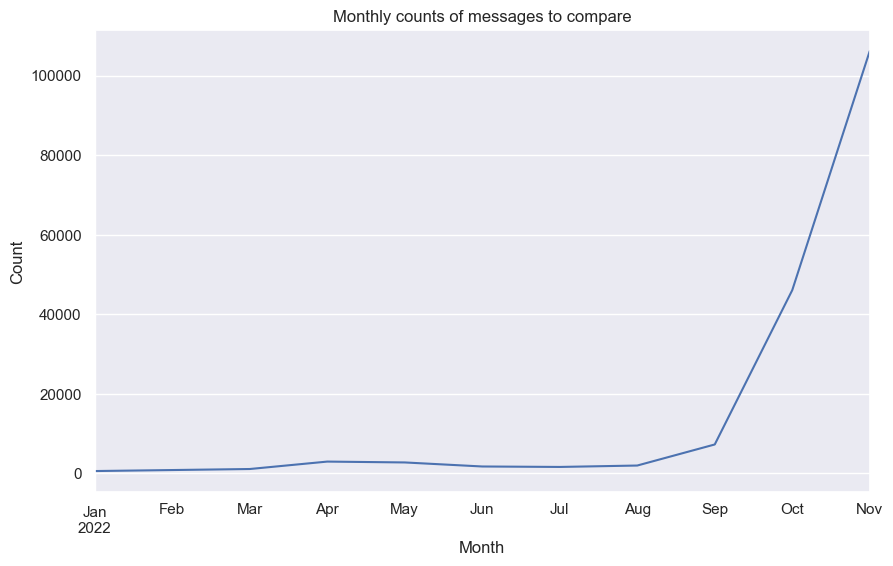

In [940]:
# plot monthly_counts
fig, ax = plt.subplots(figsize=(10, 6))
monthly_counts.plot(ax=ax)
ax.set_title('Monthly counts of messages to compare')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.show()


## Generate similarity matrix

### TFIDF approach

In [941]:
df_sim.shape

(13913, 21)

In [942]:
cols = ['id_msg', 'message_text_clean_utf8', 'cleaned_sim']
df_sim[cols].head(10)


,id_msg,message_text_clean_utf8,cleaned_sim
0,3472,#lto/usdt (binance)\nbuy zone: 0.3147-0.3229\n...,lto usdt binance\nbuy zone {NUM} {NUM} {NUM} {...
1,1748,#unfi/btc (binance)\nbuy zone: 17134-17585\nta...,unfi btc binance\nbuy zone {NUM} {NUM}\ntarget...
2,5960,#nav/btc (binance)\nbuy zone: 459-472\ntarget ...,nav btc binance\nbuy zone {NUM} {NUM}\ntarget ...
3,4125,#amb/btc (binance)\nbuy zone: 82-85\ntarget 1:...,amb btc binance\nbuy zone {NUM} {NUM}\ntarget ...
4,4095,#bts/btc (binance)\nbuy zone: 60-61\ntarget 1:...,bts btc binance\nbuy zone {NUM} {NUM}\ntarget ...
5,1397,#axs/btc (binance)\nbuy zone: 136896-140503\nt...,axs btc binance\nbuy zone {NUM} {NUM}\ntarget ...
6,6097,#rsr/btc (binance)\nbuy zone: 46-47\ntarget 1:...,rsr btc binance\nbuy zone {NUM} {NUM}\ntarget ...
7,8820,#keep/btc (binance)\nbuy zone: 1633-1676\ntarg...,keep btc binance\nbuy zone {NUM} {NUM}\ntarget...
8,1783,#steem/btc (binance)\nbuy zone: 848-871\ntarge...,steem btc binance\nbuy zone {NUM} {NUM}\ntarge...
9,5859,#iris/btc (binance)\nbuy zone: 184-189\ntarget...,iris btc binance\nbuy zone {NUM} {NUM}\ntarget...


In [943]:
#filter df_results for jan, feb and mar
# flt = df_results['date_id_1'].dt.month.isin([1, 2, 3])
# flt = df_results['date_id_1'].dt.month.isin([6])
# df_results_jan_mar = df_results[flt]
# df_results_jan_mar = df_results_jan_mar.head(10000)
# df_results_jan_mar.shape

In [944]:
tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['message_text_clean_utf8'])
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])


In [945]:
# inpunts:
# df_comp: DataFrame with the pairs of messages to compare
# tfidf_matrix: matix with the tfidf values for each message of the whole corpus - reindexed by id_msg
# id_to_index: dictionary with the index of the message in the tfidf_matrix

# output:
# - similarities2 - list with the similarities between the pairs of messages

from time import time
from joblib import Parallel, delayed
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Parallelized function to compute cosine similarity for a chunk of data
def compute_similarity_chunk(chunk, id_to_index, tfidf_matrix):
    similarities = []
    for _, row in chunk.iterrows():
        id1, id2 = row['id_1'], row['id_2']
        
        # Get the indices of the messages in the TF-IDF matrix
        idx1, idx2 = id_to_index[id1], id_to_index[id2]
        
        # Compute cosine similarity for the pair
        sim = cosine_similarity(tfidf_matrix[idx1], tfidf_matrix[idx2])[0][0]
        
        # Append the similarity result
        similarities.append(sim)
    return similarities

# Function to split dataframe into chunks
def split_dataframe(df, chunk_size):
    num_chunks = math.ceil(len(df) / chunk_size)
    return [df[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]


def get_similarities(df_comp, tfidf_matrix, df_sim):
    # Assume df_sim contains: id_msg, cleaned_sim (cleaned messages)
    # Assume df_results contains: id_1, id_2 (pairs of message IDs)

    # df_comp = df_results_jan_mar[['id_1', 'id_2']] 

    # Generate tfidf_matrix
    # tfidf_vectorizer = TfidfVectorizer()
    # tfidf_matrix = tfidf_vectorizer.fit_transform(df_sim['cleaned_sim'])
    id_to_index = {idx: i for i, idx in enumerate(df_sim['id_msg'])}

    # Set the chunk size and number of parallel jobs (cores)
    chunk_size = 10000  # You can adjust this depending on your system's memory
    n_jobs = -1  # Use all available cores (-1 means using all cores)

    # Split df_comp into chunks
    chunks = split_dataframe(df_comp, chunk_size)

    # Measure start time
    start = time()

    # Parallel computation
    results = Parallel(n_jobs=n_jobs)(delayed(compute_similarity_chunk)(chunk, id_to_index, tfidf_matrix) for chunk in chunks)

    # Flatten the results into a single list
    similarities = [sim for chunk_sims in results for sim in chunk_sims]

    end = time()
    elapsed = end - start

    return similarities


# Add the similarities to df_comp
# df_comp['similarity'] = similarities2

# Measure end time

# Output the df_comp with similarities
# print(df_comp)

# # Print total number of rows, percentage, and performance stats
# print(f"Number of rows in df_comp: {df_comp.shape[0]}")
# print(f"Number of rows in df_results: {df_results.shape[0]}")
# print(f"Percentage of df_comp: {df_comp.shape[0]/df_results.shape[0]:.2%}")
# print(f"Time taken: {elapsed:.2f} seconds")
# print(f"Number of rows per second: {df_comp.shape[0]/elapsed:.2f}")

# # Extrapolate the time to run the code for the entire df_results
# estimated_time = df_results.shape[0] / df_comp.shape[0] * elapsed
# print(f"Estimated time for the entire df_results: {estimated_time:.2f} seconds")


In [946]:

df_comp = df_results
df_comp['similarity'] = get_similarities(df_comp, tfidf_matrix, df_sim)

In [947]:
# filter df_comp by similarity > 0.8
flt = df_comp['similarity'] == 1
df_comp = df_comp[flt]

In [948]:
#sort df_comp by similarity
df_comp_sorted = df_comp.sort_values(by='similarity', ascending=False)

In [949]:
df_comp_sorted

,message_lbr,word_bin,trade_type,id_1,id_2,date_id_1,date_id_2,similarity
8385,12,29,buy,10557,12404,2022-10-03 21:06:29+00:00,2022-10-03 21:09:44+00:00,1.0
163301,11,29,buy,9910,9912,2022-11-16 02:01:26+00:00,2022-11-16 02:03:55+00:00,1.0
171786,5,18,buy,58,837,2022-04-21 17:21:41+00:00,2022-04-21 17:21:48+00:00,1.0
171785,5,18,buy,58,5957,2022-04-21 17:21:41+00:00,2022-04-21 17:21:48+00:00,1.0
169631,10,29,buy,13141,4439,2022-09-28 09:51:50+00:00,2022-09-28 09:54:01+00:00,1.0
...,...,...,...,...,...,...,...,...
103327,12,29,buy,7063,1739,2022-11-25 09:07:15+00:00,2022-11-28 10:00:50+00:00,1.0
102809,12,29,buy,2400,5416,2022-11-25 09:06:56+00:00,2022-11-25 12:13:49+00:00,1.0
102808,12,29,buy,2400,5417,2022-11-25 09:06:56+00:00,2022-11-25 12:13:49+00:00,1.0
102463,12,29,buy,5309,5416,2022-11-25 09:06:56+00:00,2022-11-25 12:13:49+00:00,1.0


In [950]:
# # filter df_comp_sorted by similarity < 0.9
# df_comp_sorted = df_comp.sort_values(by='similarity', ascending=False)
# flt = ( df_comp['distance'] < 0.4 ) & (df_comp['distance'] > 0.2)
# df_comp_sorted[flt]


In [951]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13913 entries, 0 to 13912
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   signal_id                13913 non-null  int64              
 1   source_posted_at         13913 non-null  object             
 2   message_text             13913 non-null  object             
 3   commodity                13913 non-null  object             
 4   trade_type               13902 non-null  object             
 5   telegram_user_id         8867 non-null   object             
 6   title                    13913 non-null  object             
 7   chat_id                  13913 non-null  int64              
 8   language                 13913 non-null  object             
 9   id_msg                   13913 non-null  int64              
 10  date_source_posted_at    13913 non-null  datetime64[ns, UTC]
 11  message_text_clean       139

In [952]:
def enrich_similarities(df_comp, df_sim):
    # get the messages with the ids in the df_comp using joins not changing index in the df_sim
    df_comp['id_1'] = df_comp['id_1'].astype(int)
    df_comp['id_2'] = df_comp['id_2'].astype(int)

    # drop the columns if they exist
    if 'message_text_clean_utf8_1' in df_comp.columns:
        df_comp = df_comp.drop(columns=['message_text_clean_utf8_1'])
    if 'message_text_clean_utf8_2' in df_comp.columns:
        df_comp = df_comp.drop(columns=['message_text_clean_utf8_2'])

    if 'cleaned_sim_1' in df_comp.columns:
        df_comp = df_comp.drop(columns=['cleaned_sim_1'])
    if 'cleaned_sim_2' in df_comp.columns:
        df_comp = df_comp.drop(columns=['cleaned_sim_2'])
        
    if 'date_id_1' in df_comp.columns:
        df_comp = df_comp.drop(columns=['date_id_1'])
    if 'date_id_2' in df_comp.columns:
        df_comp = df_comp.drop(columns=['date_id_2'])



    # Merge the df_comp with the df_sim to get the message text for the pairs of messages
    df_comp = df_comp.merge(df_sim[['id_msg','message_text_clean_utf8', 'cleaned_sim', 'chat_id', 'date_source_posted_at']], left_on='id_1', right_on='id_msg', 
                            how='left')
    df_comp = df_comp.rename(columns={'message_text_clean_utf8': 'message_text_clean_utf8_1', 
                                    'cleaned_sim': 'cleaned_sim_1', 'chat_id': 'chat_id_1',
                                    'date_source_posted_at': 'date_id_1'})
    df_comp = df_comp.drop(columns=['id_msg'])


    df_comp = df_comp.merge(df_sim[['id_msg','message_text_clean_utf8', 'cleaned_sim', 'chat_id', 'date_source_posted_at']], left_on='id_2', right_on='id_msg', 
                            how='left')
    df_comp = df_comp.rename(columns={'message_text_clean_utf8': 'message_text_clean_utf8_2', 
                                    'cleaned_sim': 'cleaned_sim_2', 'chat_id': 'chat_id_2',
                                    'date_source_posted_at': 'date_id_2'})
    df_comp = df_comp.drop(columns=['id_msg'])

    df_comp['distance'] = (1 - df_comp['similarity']).round(5)
    return df_comp


# df_comp.head(10)
df_comp = enrich_similarities(df_comp, df_sim)
df_comp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   message_lbr                89 non-null     int64              
 1   word_bin                   89 non-null     int64              
 2   trade_type                 89 non-null     object             
 3   id_1                       89 non-null     int64              
 4   id_2                       89 non-null     int64              
 5   similarity                 89 non-null     float64            
 6   message_text_clean_utf8_1  89 non-null     object             
 7   cleaned_sim_1              89 non-null     object             
 8   chat_id_1                  89 non-null     int64              
 9   date_id_1                  89 non-null     datetime64[ns, UTC]
 10  message_text_clean_utf8_2  89 non-null     object             
 11  cleaned_

/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_72063/2155401620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp['id_1'] = df_comp['id_1'].astype(int)
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_72063/2155401620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp['id_2'] = df_comp['id_2'].astype(int)


In [953]:
df_comp.head()

,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
0,12,29,buy,10557,12404,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:29+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
1,12,29,buy,10557,3229,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:29+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
2,12,29,buy,12405,12404,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:30+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
3,12,29,buy,12405,3229,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:30+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
4,12,29,buy,12333,444,1.0,snxusdt\nshort\nentry: 2.244-2.31132\nleverage...,snxusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-07 19:01:36+00:00,snxusdt\nshort\nentry: 2.244-2.31132\nleverage...,snxusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-10-07 19:04:16+00:00,0.0


In [954]:
# drop the columns id_msg_x and id_msg_y
# df_comp = df_comp.drop(columns=['cleaned_sim_1', 'message_text_clean_utf8_1'])


## Clustering messages

### Matriz de distancias

In [955]:
# Funcion para comparar los resultados de similitud para grupos de mensajes
def check_sim(grp_ids, sim_matrix_df_dict, messages_df, columns=["cleaned"]):
  for grp in grp_ids:
    print("------")
    print(f"Grupo: {grp}")
    flt = messages_df["id_msg"].isin(grp)
    tmp_df = messages_df[flt].sort_values("id_msg")
    # loop over tmp_df to print the df row
    for idx, row in tmp_df.iterrows():
      print(f" --- msg_id: {row['id_msg']} ---")
      print(f"{row['message_lbr']} - {row['word_bin']} - {row['trade_type']}")
      print(f" ----------")
      for column in columns:
        print(f"     ------")
        print(f"{row[column]}")
      # print(f"{row['message_text_clean_utf8']}")



    # for msg_id, msg in zip(tmp_df["id_msg"], tmp_df[column]):
    #   print(f" --- msg_id: {msg_id} ---")
    #   print(f"{msg}")
    #   print(f" ----------")
    print()
    combs = set([frozenset([id1, id2]) for id2 in grp for id1 in grp if id1 != id2])
    # get scores:
    for pair in combs:
      ids = list(pair)
      print(f"  Pair:   {ids}")
      for name, matrix in sim_matrix_df_dict.items():
        flt = (df_comp['id_1'] == ids[0]) & (df_comp['id_2'] == ids[1]) | (df_comp['id_1'] == ids[1]) & (df_comp['id_2'] == ids[0])
        distance_val = matrix[flt]['distance'].tolist()
        # get the value of matrix[flt]['distance'] to get the distance
        print(distance_val)
        if distance_val != []:
          print(f"      {name} - {distance_val[0]}")
        else:
          print(f"      {name} - No distance calculated")
        

    print()


In [956]:
def get_labels_groups(labels, id_list=None):
    ''''
    Function to get the groups of messages based on the labels
    labels: list of labels received from the clustering algorithm AgglomerativeClustering
    [1,2,3,2,2,1] -> {1: [0, 5], 2: [1, 3, 4], 3: [2]}
    and with id_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    -> {1: [10, 60], 2: [20, 40, 50], 3: [30]}
    
    By default, the function will use the index as the id
    If id_list is provided, the function will use the id_list to get the id
    in the index position
    '''
    positions_dict = {}
    if id_list is not None:
        def get_id(index):
            return id_list[index]
    else:
        def get_id(index):
            return index

    for index, value in enumerate(labels):
        id = get_id(index)
        if value in positions_dict:
            positions_dict[value].append(id)
        else:
            positions_dict[value] = [id]
    return positions_dict


In [957]:
df_comp_flt = df_comp
# filter the df_comp by distance > 0.5
flt = (df_comp_flt['distance'] < 0.4)  & (df_comp_flt['distance'] > 0.0)
df_comp_flt = df_comp_flt[flt]    
df_comp_flt


,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance


In [958]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [959]:
def init_similarity_dict_old(df_comp, ids_check=[]):
    # Get unique ids
    ids = pd.unique(df_comp[['id_1', 'id_2']].values.ravel())
    id_to_index = {id_val: i for i, id_val in enumerate(ids)}

    print(f"Ids: {ids_check}")
    print(f"in df_comp: {list(set(ids_check).intersection(ids))}")

    # Create row, column, and distance values
    row = [id_to_index[id1] for id1 in df_comp['id_1']]
    col = [id_to_index[id2] for id2 in df_comp['id_2']]
    distances = df_comp['similarity']

    # Create a sparse matrix in CSR format
    n = len(ids)  # Total number of unique ids
    sparse_matrix = csr_matrix((distances, (row, col)), shape=(n, n))

    # Since the matrix is symmetric, add the transpose to fill the lower triangle
    sparse_matrix = sparse_matrix + sparse_matrix.T
    return {'id_to_index': id_to_index,
            "ids": ids,
            "sim_matrix": sparse_matrix}



In [960]:
def init_similarity_dict(df_comp, ids_check=[]):
    # Get unique ids
    ids = pd.unique(df_comp[['id_1', 'id_2']].values.ravel())
    id_to_index = {id_val: i for i, id_val in enumerate(ids)}

    set_ids_check = set(ids_check)
    intersection_ids = set_ids_check.intersection(ids)
    if set_ids_check == intersection_ids:
        print("All ids in ids_check are in the df_comp")
    else:
        print(f"Ids in ids_check not in df_comp: {set_ids_check - intersection_ids}")

    # Create row, column, and distance values
    row = [id_to_index[id1] for id1 in df_comp['id_1']]
    col = [id_to_index[id2] for id2 in df_comp['id_2']]
    distances = df_comp['similarity']

    sim_dict = df_comp[['id_1', 'id_2', 'similarity']].to_dict(orient='records')
    # print(sim_dict)
    # Create a sparse matrix in CSR format
    n = len(ids)  # Total number of unique ids
    matrix = np.zeros((n, n))

    # print(f"Matrix shape: {matrix.shape}")

    # loop over sim_dict
    for sim in sim_dict:
        # print(sim)
        id1 = sim['id_1']
        id2 = sim['id_2']
        sim_val = sim['similarity']
        i = id_to_index[id1]
        j = id_to_index[id2]
        # print(f"i: {i}, j: {j}, sim: {sim_val}")
        matrix[i, j] = sim_val
        matrix[j, i] = sim_val

    return {'id_to_index': id_to_index,
            "ids": ids,
            "sim_matrix": matrix}



In [961]:
df_comp_flt

,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance


In [962]:
# similarity_dict = init_similarity_dict(df_comp)
similarity_dict_old = init_similarity_dict_old(df_comp)
kk1 = similarity_dict_old['sim_matrix'].toarray()
print(kk1)
# similarity_dict = init_similarity_dict(df_comp_flt)

similarity_dict = init_similarity_dict(df_comp)
kk = similarity_dict['sim_matrix']
print(kk)

# verify that the two matrices are the same
np.array_equal(kk, kk1)






Ids: []
in df_comp: []
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
All ids in ids_check are in the df_comp
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


True

In [963]:
from sklearn.cluster import AgglomerativeClustering


In [964]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   message_lbr                89 non-null     int64              
 1   word_bin                   89 non-null     int64              
 2   trade_type                 89 non-null     object             
 3   id_1                       89 non-null     int64              
 4   id_2                       89 non-null     int64              
 5   similarity                 89 non-null     float64            
 6   message_text_clean_utf8_1  89 non-null     object             
 7   cleaned_sim_1              89 non-null     object             
 8   chat_id_1                  89 non-null     int64              
 9   date_id_1                  89 non-null     datetime64[ns, UTC]
 10  message_text_clean_utf8_2  89 non-null     object             
 11  cleaned_

In [965]:
# filter df_comp by id_1 and id_2 ==11921
flt = (df_comp['id_1'] == 11921) | (df_comp['id_2'] == 11921)
df_comp_11921 = df_comp[flt]
df_comp_11921


,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
13,12,29,buy,11977,11921,1.0,dashusdt\nlong\nentry: 41.38-40.1386\nleverage...,dashusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-16 13:02:38+00:00,dashusdt\nlong\nentry: 41.38-40.1386\nleverage...,dashusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,181,2022-10-16 13:07:21+00:00,0.0
15,12,29,buy,186,11921,1.0,dashusdt\nlong\nentry: 41.38-40.1386\nleverage...,dashusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-16 13:02:39+00:00,dashusdt\nlong\nentry: 41.38-40.1386\nleverage...,dashusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,181,2022-10-16 13:07:21+00:00,0.0


In [1047]:
from sklearn.cluster import AffinityPropagation

# for each group of messages, get the clusters
# 1. get the labels
# 2. get the groups
# 3. get the messages in each group
# 4. get the messages in each cluster

# loop over the groups
# for each group, get the clusters


def gen_cluster(df_comp, method='AffinityPropagation'):
    # loop over df_grouped
    results = []
    ctrl_duplicated = {}
    tokenization = {}

    # group df_comp by message_lbr, word_bin and trade_type
    df_grouped = df_comp.groupby(['message_lbr', 'word_bin', 'trade_type'], dropna=False)
    # transform the groupby object to a DataFrame
    df_grouped = df_grouped.size().reset_index(name='count')
    
    clusters = []
    # for idx, row in df_grouped2.head(1).iterrows():
    for idx, row in df_grouped.iterrows():
        # print the row
        message_lbr= row['message_lbr']
        word_bin= row['word_bin']
        trade_type= row['trade_type']
        count= row['count']
        print(f"message_lbr: {message_lbr}, word_bin: {word_bin}, trade_type: {trade_type}, count: {count}")

        # filter df by message_lbr, word_bin and commodity 
        if trade_type == '{Not Specified}':
            flt = (df_comp['message_lbr'] == message_lbr) & (df_comp['word_bin'] == word_bin) & df_comp['trade_type'].isnull()
        else:
            flt = (df_comp['message_lbr'] == message_lbr) & (df_comp['word_bin'] == word_bin) & (df_comp['trade_type'] == trade_type)
        
        grp_src = df_comp[flt]
        sim_dict = init_similarity_dict(grp_src, [11921, 10405]) # TODO - fix use: init_similarity_dict
        sim_matrix = sim_dict['sim_matrix']
        if method == 'AgglomerativeClustering':
            build_gpr = AgglomerativeClustering(metric='precomputed', linkage='complete', compute_full_tree=True, n_clusters=None, distance_threshold=0.5)
            # cur_labels = build_gpr.fit_predict(1- sim_matrix.toarray())
            cur_labels = build_gpr.fit_predict(1- sim_matrix)
        elif method == 'AffinityPropagation':
            build_gpr = AffinityPropagation(affinity='precomputed', random_state=42)
            # print(sim_matrix.toarray())
            print(sim_matrix)
            # build_gpr.fit(sim_matrix.toarray().astype(np.float64))
            build_gpr.fit(sim_matrix.astype(np.float64))
            cur_labels = build_gpr.labels_
        else:
            raise ValueError(f"Method {method} not implemented")
            
        # print("distance_matrix")
        # print(1- sim_matrix.toarray())
        
        try:
            grps_cluster = get_labels_groups(cur_labels, sim_dict['ids'])
        except Exception as e:
            return cur_labels, sim_dict['ids'], sim_dict['sim_matrix']
        grp_ids_cluster = [v for k, v in grps_cluster.items() if len(v) > 1]
        # print(grp_ids_cluster)
        clusters.append(grp_ids_cluster)
    return clusters

# clusters_agglomerative = gen_cluster(df_comp, 'AgglomerativeClustering')
# df_grouped['agglomerative'] = clusters_agglomerative

#clusters_affinity_propagation = gen_cluster(df_comp, 'AffinityPropagation')


flt_small = (df_comp['message_lbr'] == 12) & (df_comp['word_bin'] == 29) & (df_comp['trade_type'] == 'buy')
df_comp_test = df_comp[flt_small]
# clusters_affinity_propagation = gen_cluster(df_comp_test, 'AffinityPropagation')

clusters_affinity_propagation = gen_cluster(df_comp_test, 'AffinityPropagation')
clusters_agglomerative = gen_cluster(df_comp_test, 'AgglomerativeClustering')
# df_grouped['affinity-propagation'] = clusters_affinity_propagation


# labels, ids, matrix = gen_cluster(df_comp, 'AffinityPropagation')

# clustering = AgglomerativeClustering(metric='precomputed', linkage='complete', compute_full_tree=True, n_clusters=None, distance_threshold=0.3)
# labels = clustering.fit_predict(distances)

# print("Labels:", labels)
# grps_cluster = get_labels_groups(labels)
# print(grps_cluster)

message_lbr: 12, word_bin: 29, trade_type: buy, count: 38
All ids in ids_check are in the df_comp
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
message_lbr: 12, word_bin: 29, trade_type: buy, count: 38
All ids in ids_check are in the df_comp


/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [1034]:
clusters_affinity_propagation

[[[10557, 3229, 12405],
  [12404, 5416, 3042],
  [12333, 4039, 10442],
  [444, 4202, 4210],
  [12233, 7635, 12227, 96],
  [12039, 13682, 13672, 2512],
  [11977, 186, 5309, 5417, 2400],
  [11921, 10405, 4042],
  [10441, 2521],
  [7063, 1739, 5187],
  [1686, 2960, 2588]]]

In [1049]:
clusters_agglomerative = gen_cluster(df_comp, 'AgglomerativeClustering')
clusters_agglomerative

message_lbr: 1, word_bin: 20, trade_type: buy, count: 6
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 1, word_bin: 22, trade_type: buy, count: 1
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 1, word_bin: 29, trade_type: buy, count: 4
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 3, word_bin: 19, trade_type: buy, count: 4
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 4, word_bin: 14, trade_type: buy, count: 3
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 4, word_bin: 18, trade_type: buy, count: 1
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 4, word_bin: 21, trade_type: buy, count: 2
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 5, word_bin: 18, trade_type: buy, count: 3
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 7, word_bin: 29, trade_type: buy, count: 14
Ids in ids_check not in df_comp: {11921, 10405}
message_lbr: 10, word_bin: 29, trade_type: buy, count: 1
Ids in

[[[2562, 1743], [2557, 1720], [2546, 2596], [1717, 2592], [1714, 2601]],
 [[2598, 1678]],
 [[1728, 2590], [1801, 2586], [2597, 1676], [1723, 1722]],
 [[1516, 1825], [9548, 7292], [5494, 3391]],
 [[13764, 13877, 13829]],
 [[4445, 32]],
 [[9786, 8988], [1592, 1934]],
 [[58, 5957, 837]],
 [[667, 8446],
  [764, 8388],
  [680, 8089],
  [649, 8090],
  [507, 13361],
  [553, 8653],
  [554, 8605],
  [582, 8641],
  [588, 8566],
  [556, 8603],
  [586, 8639],
  [376, 8258],
  [13183, 8133],
  [409, 8461]],
 [[13141, 4439]],
 [[13626, 13630], [13641, 13627], [9909, 2128], [9912, 9910], [7219, 7220]],
 [[10557, 12404],
  [3229, 12405],
  [12333, 444],
  [4202, 4210],
  [12233, 7635],
  [12039, 13682],
  [11977, 96],
  [11921, 186],
  [10441, 4039],
  [10405, 10442],
  [5309, 5417],
  [5416, 2400],
  [7063, 1739],
  [2521, 1686],
  [2960, 3042]],
 [[9817, 13719]],
 [[13559, 13540]]]

In [1035]:
# filter df_comp_test by id_1 in 11921, 10405, 4042 or id_2 in 11921, 10405, 4042
# flt = (df_comp_test['id_1'] == 11921) | (df_comp_test['id_2'] == 11921) | (df_comp_test['id_1'] == 10405) | (df_comp_test['id_2'] == 10405) | (df_comp_test['id_1'] == 4042) | (df_comp_test['id_2'] == 4042)
message_lbr = 12
word_bin = 29
trade_type = 'buy'
flt = (df_comp['message_lbr'] == message_lbr) & (df_comp['word_bin'] == word_bin) & (df_comp['trade_type'] == trade_type)
df_comp_test2 = df_comp_test[flt]
df_comp_test2

/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_72063/629157491.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_comp_test2 = df_comp_test[flt]


,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
0,12,29,buy,10557,12404,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:29+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
1,12,29,buy,10557,3229,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:29+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
2,12,29,buy,12405,12404,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:30+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
3,12,29,buy,12405,3229,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:30+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
4,12,29,buy,12333,444,1.0,snxusdt\nshort\nentry: 2.244-2.31132\nleverage...,snxusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-07 19:01:36+00:00,snxusdt\nshort\nentry: 2.244-2.31132\nleverage...,snxusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-10-07 19:04:16+00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,12,29,buy,3042,2960,1.0,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-11-26 14:10:40+00:00,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-11-26 14:12:43+00:00,0.0
34,12,29,buy,1686,2588,1.0,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-11-26 14:12:43+00:00,roseusdt\nlong\nentry: 0.04732-0.0459004\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-11-30 23:35:32+00:00,0.0
35,12,29,buy,1686,2512,1.0,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-11-26 14:12:43+00:00,roseusdt\nlong\nentry: 0.04732-0.0459004\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-11-30 23:35:32+00:00,0.0
36,12,29,buy,2960,2588,1.0,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-11-26 14:12:43+00:00,roseusdt\nlong\nentry: 0.04732-0.0459004\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-11-30 23:35:32+00:00,0.0


In [1036]:
sim_dict = init_similarity_dict(df_comp_test2, [11921, 10405]) # TODO - fix use: init_similarity_dict
sim_matrix = sim_dict['sim_matrix']

All ids in ids_check are in the df_comp


In [1037]:
sim_dict['ids']

array([10557, 12404,  3229, 12405, 12333,   444,  4202,  4210, 12233,
        7635, 12227, 12039, 13682, 13672, 11977,    96, 11921,   186,
       10441,  4039, 10405, 10442,  4042,  7468,  5309,  5417,  5416,
        2400,  7063,  1739,  5187,  2521,  1686,  2960,  3042,  2588,
        2512])

In [1038]:
sim_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1046]:
print(sim_dict['id_to_index'][11921])
print(sim_dict['id_to_index'][10405])
print(sim_dict['id_to_index'][4042])
print(sim_matrix[16, 20])
print(sim_matrix[16, 22])
print(sim_matrix[22, 20])

16
20
22
0.0
0.0
1.0


In [1039]:
build_gpr = AffinityPropagation(affinity='precomputed', random_state=42)
build_gpr.fit(sim_matrix.astype(np.float64))
cur_labels = build_gpr.labels_

cur_labels

/Users/jbaudoin/.pyenv/versions/mentoria-3.10.14/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


array([ 0, 10,  0,  0,  5,  1,  1,  1,  2,  2,  2,  3,  3,  3,  8,  2,  6,
        8,  4,  5,  6,  5,  6,  7,  8,  8, 10,  8,  9,  9,  9,  4, 11, 11,
       10, 11,  3])

In [1040]:
grps_cluster = get_labels_groups(cur_labels, sim_dict['ids'])
grps_cluster

{0: [10557, 3229, 12405],
 10: [12404, 5416, 3042],
 5: [12333, 4039, 10442],
 1: [444, 4202, 4210],
 2: [12233, 7635, 12227, 96],
 3: [12039, 13682, 13672, 2512],
 8: [11977, 186, 5309, 5417, 2400],
 6: [11921, 10405, 4042],
 4: [10441, 2521],
 7: [7468],
 9: [7063, 1739, 5187],
 11: [1686, 2960, 2588]}

In [1031]:
grp_ids_cluster = [v for k, v in grps_cluster.items() if len(v) > 1]
grp_ids_cluster

[[11977, 11921, 186], [10441, 10405, 10442, 4042, 4039, 7468]]

In [1032]:
clusters_affinity_propagation

[[[10557, 3229, 12405],
  [12404, 5416, 3042],
  [12333, 4039, 10442],
  [444, 4202, 4210],
  [12233, 7635, 12227, 96],
  [12039, 13682, 13672, 2512],
  [11977, 186, 5309, 5417, 2400],
  [11921, 10405, 4042],
  [10441, 2521],
  [7063, 1739, 5187],
  [1686, 2960, 2588]]]

In [969]:
df_comp

,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
0,12,29,buy,10557,12404,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:29+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
1,12,29,buy,10557,3229,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:29+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
2,12,29,buy,12405,12404,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:30+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
3,12,29,buy,12405,3229,1.0,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-10-03 21:06:30+00:00,thetausdt\nlong\nentry: 1.059-1.02723\nleverag...,thetausdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}...,181,2022-10-03 21:09:44+00:00,0.0
4,12,29,buy,12333,444,1.0,snxusdt\nshort\nentry: 2.244-2.31132\nleverage...,snxusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-07 19:01:36+00:00,snxusdt\nshort\nentry: 2.244-2.31132\nleverage...,snxusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-10-07 19:04:16+00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,3,19,buy,1516,1825,1.0,#cfx (binance)\nbuy zone 353-382\nsell zone 39...,cfx binance\nbuy zone {NUM} {NUM}\nsell zone {...,19,2022-02-26 07:11:59+00:00,#cfx (binance)\nbuy zone 353-382\nsell zone 39...,cfx binance\nbuy zone {NUM} {NUM}\nsell zone {...,1751,2022-02-26 18:49:34+00:00,0.0
85,3,19,buy,11146,1825,1.0,#cfx (binance)\nbuy zone 353-382\nsell zone 39...,cfx binance\nbuy zone {NUM} {NUM}\nsell zone {...,19,2022-02-26 18:49:32+00:00,#cfx (binance)\nbuy zone 353-382\nsell zone 39...,cfx binance\nbuy zone {NUM} {NUM}\nsell zone {...,1751,2022-02-26 18:49:34+00:00,0.0
86,3,19,buy,9548,7292,1.0,#lsk (binance)\nbuy zone 4620-5070\nsell zone ...,lsk binance\nbuy zone {NUM} {NUM}\nsell zone {...,19,2022-03-07 18:53:04+00:00,#lsk (binance)\nbuy zone 4620-5070\nsell zone ...,lsk binance\nbuy zone {NUM} {NUM}\nsell zone {...,1865,2022-03-07 18:53:36+00:00,0.0
87,3,19,buy,5494,3391,1.0,#multi (binance)\nbuy zone 2974-3270\nsell zon...,multi binance\nbuy zone {NUM} {NUM}\nsell zone...,19,2022-04-06 04:48:06+00:00,#multi (binance)\nbuy zone 2974-3270\nsell zon...,multi binance\nbuy zone {NUM} {NUM}\nsell zone...,1865,2022-04-06 04:48:39+00:00,0.0


In [1021]:
clusters_affinity_propagation


[[[10557, 3229, 12405],
  [12404, 5416, 3042],
  [12333, 4039, 10442],
  [444, 4202, 4210],
  [12233, 7635, 12227, 96],
  [12039, 13682, 13672, 2512],
  [11977, 186, 5309, 5417, 2400],
  [11921, 10405, 4042],
  [10441, 2521],
  [7063, 1739, 5187],
  [1686, 2960, 2588]]]

In [971]:
# count the number of clusters in clusters_affinity_propagation
total = 0
for idx, cluster in enumerate(clusters_affinity_propagation):
    clusters_in_grp = len(cluster)
    print(f"grp {idx}: {clusters_in_grp}")
    total += clusters_in_grp
print(f"Total number of clusters: {total}")

grp 0: 5
grp 1: 1
grp 2: 4
grp 3: 3
grp 4: 1
grp 5: 1
grp 6: 1
grp 7: 1
grp 8: 12
grp 9: 1
grp 10: 1
grp 11: 11
grp 12: 1
grp 13: 1
Total number of clusters: 44


In [972]:
clusters_affinity_propagation[1]

[[2598, 1678]]

In [1015]:
from itertools import chain
# ids = set(list(chain.from_iterable(clusters_affinity_propagation[0])))

ids = clusters_affinity_propagation[1][0]
ids = [11921, 10405, 4042]

print(ids)

# filter df_comp by message_lbr: 1, word_bin: 14, trade_type: buy, count: 357
flt = df_comp['id_1'].isin(ids) & df_comp['id_2'].isin(ids)
df_comp_flt = df_comp[flt]
df_comp_flt

[11921, 10405, 4042]


,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
21,12,29,buy,4042,10405,1.0,maskusdt\nlong\nentry: 1.045-1.01365\nleverage...,maskusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-23 17:20:27+00:00,maskusdt\nlong\nentry: 1.045-1.01365\nleverage...,maskusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,114,2022-10-23 18:35:11+00:00,0.0


In [974]:
cols = ['id_msg', 'message_lbr_utf8', 'message_lbr', 'word_bin', 'message_words_utf8', 'message_words', 'message_text_clean_utf8', 'cleaned_sim']
# df_sim[cols].sample(5)
# filter by id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
# [1678, 2606, 1814, 1811, 2598, 1797, 1799]
flt = df_sim['id_msg'].isin(ids)
df_sim[cols][flt]

,id_msg,message_lbr_utf8,message_lbr,word_bin,message_words_utf8,message_words,message_text_clean_utf8,cleaned_sim
11990,1678,1,1,22,14,22,ocr:\n#mdx (binance) buy zone 312-339 sell zon...,ocr\nmdx binance buy zone {NUM} {NUM} sell zon...
12075,2598,1,1,22,14,22,ocr:\n#mdx (binance) buy zone 312-339 sell zon...,ocr\nmdx binance buy zone {NUM} {NUM} sell zon...


In [1016]:
grp_ids_cluster = [ids]
cfg = {
    "Cosine": df_comp,
}
# check_sim(grp_ids_cluster, cfg, df_sim, ['cleaned_sim', 'message_text_clean_utf8'])
check_sim(grp_ids_cluster, cfg, df_sim, ['cleaned_sim'])

------
Grupo: [11921, 10405, 4042]
 --- msg_id: 4042 ---
12 - 29 - buy
 ----------
     ------
maskusdt
long
entry {NUM} {NUM} {NUM} {NUM}
leverage cross 25x
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
stop loss {NUM}
 --- msg_id: 10405 ---
12 - 29 - buy
 ----------
     ------
maskusdt
long
entry {NUM} {NUM} {NUM} {NUM}
leverage cross 25x
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
stop loss {NUM}
 --- msg_id: 11921 ---
12 - 29 - buy
 ----------
     ------
dashusdt
long
entry {NUM} {NUM} {NUM} {NUM}
leverage cross 25x
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
target {NUM} {NUM}
stop loss {NUM}

  Pair:   [4042, 10405]
[0.0]
      Cosine - 0.0
  Pair:   [11921, 4042]
[]
      Cosine 

In [976]:
df_grouped

,message_lbr,word_bin,trade_type,count
205,16,29,buy,2194
193,12,29,buy,2015
145,8,29,buy,1338
184,11,29,buy,1172
201,14,29,buy,950
...,...,...,...,...
108,6,20,buy,1
106,6,18,sell,1
102,6,15,buy,1
101,6,10,buy,1


In [977]:
# get_similarities(df_comp, tfidf_matrix, df_sim)
clusters_affinity_propagation


[[[2562, 1743, 2551], [2557, 1720], [2546, 2596], [1717, 2592], [1714, 2601]],
 [[2598, 1678]],
 [[1728, 2590], [1801, 2586], [2597, 1676], [1723, 1722]],
 [[1516, 1825, 11146], [9548, 7292], [5494, 3391]],
 [[13764, 13877, 13829]],
 [[4445, 32]],
 [[9786, 8988, 1592, 1934]],
 [[58, 5957, 837]],
 [[667, 8446],
  [764, 8566],
  [680, 8089],
  [507, 13361],
  [553, 8653],
  [554, 8605, 588],
  [582, 8641],
  [556, 8603],
  [586, 8639],
  [376, 8258],
  [13183, 8133],
  [409, 8461]],
 [[13141, 4439]],
 [[13626, 13630, 13641, 13627, 9909, 2128, 9912, 9910, 7219, 7220, 7218]],
 [[10557, 3229, 12405],
  [12404, 5416, 3042],
  [12333, 4039, 10442],
  [444, 4202, 4210],
  [12233, 7635, 12227, 96],
  [12039, 13682, 13672, 2512],
  [11977, 186, 5309, 5417, 2400],
  [11921, 10405, 4042],
  [10441, 2521],
  [7063, 1739, 5187],
  [1686, 2960, 2588]],
 [[9817, 13719]],
 [[13559, 13540]]]

In [978]:
from itertools import chain
# List of list of clusters
kk = [[clusters_affinity_propagation[1][0]]]

kk2 = list(chain.from_iterable(kk))

def gen_clusters_groups_df(clusters_groups):
    compare_list = []
    cluster_grp_id = -1
    cluster_count = 0
    print(f'Total number of groups: {len(clusters_groups)}')
    for cluster_grp in clusters_groups:
        cluster_grp_id += 1
        print(f'Total number of cluster in group {cluster_grp_id}: {len(cluster_grp)}')
        cluster_id = -1
        for cluster in cluster_grp:
            cluster_id += 1
            cluster_count += 1
            # combine the lists by pairs with no repetitions
            combs = set([frozenset([id1, id2]) for id2 in cluster for id1 in cluster if id1 != id2])
            # print(combs)
            for pair in combs:
                lpair = list(pair)
                compare_list.append({
                    'c_id': f'{cluster_grp_id}-{cluster_id}',
                    'c_grp': cluster_grp_id,
                    'sc_id': cluster_id,
                    'id_1': lpair[0], 'id_2': lpair[1]})
                # print(pair)
                # print(pair[0], pair[1])

        # generate a dataframe from compare_list
    clusters_compare_df = pd.DataFrame.from_dict(compare_list)
    print(f'Total number of clusters: {cluster_count}')
    return clusters_compare_df

In [1050]:
# clusters_compare_df = gen_clusters_groups_df(clusters_affinity_propagation)

clusters_compare_df = gen_clusters_groups_df(clusters_agglomerative)


Total number of groups: 14
Total number of cluster in group 0: 5
Total number of cluster in group 1: 1
Total number of cluster in group 2: 4
Total number of cluster in group 3: 3
Total number of cluster in group 4: 1
Total number of cluster in group 5: 1
Total number of cluster in group 6: 2
Total number of cluster in group 7: 1
Total number of cluster in group 8: 14
Total number of cluster in group 9: 1
Total number of cluster in group 10: 5
Total number of cluster in group 11: 15
Total number of cluster in group 12: 1
Total number of cluster in group 13: 1
Total number of clusters: 55


In [1051]:
clusters_compare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c_id    59 non-null     object
 1   c_grp   59 non-null     int64 
 2   sc_id   59 non-null     int64 
 3   id_1    59 non-null     int64 
 4   id_2    59 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.4+ KB


In [1052]:
clusters_similarities =  get_similarities(clusters_compare_df, tfidf_matrix, df_sim)

In [1053]:
clusters_compare_df['similarity'] = clusters_similarities

# enrich the similarities
clusters_compare_df = enrich_similarities(clusters_compare_df, df_sim)




In [1054]:
clusters_compare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   c_id                       59 non-null     object             
 1   c_grp                      59 non-null     int64              
 2   sc_id                      59 non-null     int64              
 3   id_1                       59 non-null     int64              
 4   id_2                       59 non-null     int64              
 5   similarity                 59 non-null     float64            
 6   message_text_clean_utf8_1  59 non-null     object             
 7   cleaned_sim_1              59 non-null     object             
 8   chat_id_1                  59 non-null     int64              
 9   date_id_1                  59 non-null     datetime64[ns, UTC]
 10  message_text_clean_utf8_2  59 non-null     object             
 11  cleaned_

In [1055]:
clusters_compare_df

,c_id,c_grp,sc_id,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
0,0-0,0,0,2562,1743,1.0,ocr:\n#ast (binance) buy zone 540-575 sell zon...,ocr\nast binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-06 09:20:57+00:00,ocr:\n#ast (binance) buy zone 634-688 sell zon...,ocr\nast binance buy zone {NUM} {NUM} sell zon...,1735,2022-10-13 05:02:39+00:00,0.0
1,0-1,0,1,1720,2557,1.0,ocr:\n#qkc (binance) buy zone 51-55 sell zone ...,ocr\nqkc binance buy zone {NUM} {NUM} sell zon...,1735,2022-10-13 04:57:31+00:00,ocr:\n#qkc (binance) buy zone 51-55 sell zone ...,ocr\nqkc binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-13 04:57:14+00:00,0.0
2,0-2,0,2,2546,2596,1.0,ocr:\n#nebl (binance) buy zone 15107-16407 sel...,ocr\nnebl binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-13 06:22:15+00:00,ocr:\n#nebl (binance) buy zone 15107-16407 sel...,ocr\nnebl binance buy zone {NUM} {NUM} sell zo...,1735,2022-10-13 06:22:32+00:00,0.0
3,0-3,0,3,2592,1717,1.0,ocr:\n#wabi (binance) buy zone 497-548 sell zo...,ocr\nwabi binance buy zone {NUM} {NUM} sell zo...,1735,2022-10-13 08:14:37+00:00,ocr:\n#wabi (binance) buy zone 497-548 sell zo...,ocr\nwabi binance buy zone {NUM} {NUM} sell zo...,1751,2022-10-13 08:14:20+00:00,0.0
4,0-4,0,4,2601,1714,1.0,ocr:\n#vgx (binance) buy zone 2112-2293 sell z...,ocr\nvgx binance buy zone {NUM} {NUM} sell zon...,1735,2022-10-14 08:12:31+00:00,ocr:\n#vgx (binance) buy zone 2112-2293 sell z...,ocr\nvgx binance buy zone {NUM} {NUM} sell zon...,1751,2022-10-14 08:12:14+00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,11-12,11,12,1739,7063,1.0,roseusdt\nshort\nentry: 0.04479-0.0461337\nlev...,roseusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,219,2022-11-28 10:00:50+00:00,roseusdt\nshort\nentry: 0.04496-0.0463088\nlev...,roseusdt\nshort\nentry {NUM} {NUM} {NUM} {NUM}...,173,2022-11-25 09:07:15+00:00,0.0
55,11-13,11,13,2521,1686,1.0,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-11-26 14:10:39+00:00,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-11-26 14:12:43+00:00,0.0
56,11-14,11,14,2960,3042,1.0,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,179,2022-11-26 14:12:43+00:00,roseusdt\nlong\nentry: 0.04639-0.0449983\nleve...,roseusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-11-26 14:10:40+00:00,0.0
57,12-0,12,0,9817,13719,1.0,bakeusdt long-\ncoin : bakeusdt\ntype : long\n...,bakeusdt long\ncoin bakeusdt\ntype long\nlever...,1912,2022-03-27 21:43:33+00:00,bakeusdt long-\ncoin : bakeusdt\ntype : long\n...,bakeusdt long\ncoin bakeusdt\ntype long\nlever...,2820,2022-03-30 13:53:21+00:00,0.0


In [1056]:
import textwrap

def print_side_by_side2(message1, message2, width=30):
    # Split and wrap both messages into lines of a given width
    lines1 = textwrap.wrap(message1, width=width)
    lines2 = textwrap.wrap(message2, width=width)

    # Get the maximum number of lines between both messages
    max_lines = max(len(lines1), len(lines2))

    # Pad messages with empty lines if necessary
    lines1 += [''] * (max_lines - len(lines1))
    lines2 += [''] * (max_lines - len(lines2))

    # Print both messages side by side
    for line1, line2 in zip(lines1, lines2):
        print(f'{line1:<{width}} | {line2:<{width}}')

def print_side_by_side(message1, message2, width=30, linebreak_symbol='↵'):
    # Split both messages into lines, preserving line breaks
    # replace linebreaks with a symbol and a linebreak
    message1 = message1.replace('\n', f'{linebreak_symbol}\n')
    message2 = message2.replace('\n', f'{linebreak_symbol}\n')
    lines1 = message1.splitlines()
    lines2 = message2.splitlines()

    # Apply textwrap.wrap to each individual line while preserving line breaks
    wrapped_lines1 = [textwrap.wrap(line, width=width) if line else [linebreak_symbol] for line in lines1]
    wrapped_lines2 = [textwrap.wrap(line, width=width) if line else [linebreak_symbol] for line in lines2]

    # Flatten the lists of wrapped lines
    flattened_lines1 = [item for sublist in wrapped_lines1 for item in (sublist or [''])]
    flattened_lines2 = [item for sublist in wrapped_lines2 for item in (sublist or [''])]

    # Get the maximum number of lines between both messages
    max_lines = max(len(flattened_lines1), len(flattened_lines2))

    # Pad messages with empty lines if necessary
    flattened_lines1 += [''] * (max_lines - len(flattened_lines1))
    flattened_lines2 += [''] * (max_lines - len(flattened_lines2))

    # Print both messages side by side
    for line1, line2 in zip(flattened_lines1, flattened_lines2):
        print(f'{line1:<{width}} | {line2:<{width}}')



# generate a function that prints the messages  with similarities > 0.3
def check_sim_clusters(clusters_compare_df, sim_threshold=[0.3, 0.4], width=50):
    flt = (clusters_compare_df['similarity'] >= sim_threshold[0]) & (clusters_compare_df['similarity'] <= sim_threshold[1])
    # filter by chat_id_1 != chat_id_2
    flt = flt & (clusters_compare_df['chat_id_1'] != clusters_compare_df['chat_id_2'])
    df_comp_flt = clusters_compare_df[flt].head(50).tail(10)
    # loop over df_comp_flt and print the messages
    for idx, row in df_comp_flt.iterrows():
        print(f" --- {row['c_id']} ---")
        print(f"Similarity: {row['similarity']}")
        # print 100 times the character '-'
        print("_" * (width*2+1))
        print_side_by_side(f'Chat ID: {row["chat_id_1"]}', f'Chat ID: {row["chat_id_2"]}', width=width)
        print_side_by_side(row['message_text_clean_utf8_1'], row['message_text_clean_utf8_2'], width=width)
        print("_" * (width*2+1))
        print()


# generate a function that prints the messages  with similarities > 0.3
def check_sim_chats(clusters_compare_df, chat_a, chat_b, width=50):
    
    # filter by chat_id_1 in chat_list  and chat_id_2 in chat_list
    flt = ((clusters_compare_df['chat_id_1'] == chat_a) & (clusters_compare_df['chat_id_2'] == chat_b))
    flt = flt | ((clusters_compare_df['chat_id_1'] == chat_b) & (clusters_compare_df['chat_id_2'] == chat_a))

    df_comp_flt = clusters_compare_df[flt].head(50).tail(10)
    # loop over df_comp_flt and print the messages
    for idx, row in df_comp_flt.iterrows():
        print(f" --- {row['c_id']} ---")
        print(f"Similarity: {row['similarity']}")
        # print 100 times the character '-'
        print("_" * (width*2+1))
        print_side_by_side(f'Chat ID: {row["chat_id_1"]}', f'Chat ID: {row["chat_id_2"]}', width=width)
        print_side_by_side(f'Msg ID: {row["id_1"]} - Fecha: {row["date_id_1"]}', f'Msg ID: {row["id_2"]} - Fecha: {row["date_id_2"]}', width=width)
        print("-" * (width*2+1))
        print_side_by_side(row['message_text_clean_utf8_1'], row['message_text_clean_utf8_2'], width=width)
        print("_" * (width*2+1))
        print()


In [1057]:
clusters_compare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   c_id                       59 non-null     object             
 1   c_grp                      59 non-null     int64              
 2   sc_id                      59 non-null     int64              
 3   id_1                       59 non-null     int64              
 4   id_2                       59 non-null     int64              
 5   similarity                 59 non-null     float64            
 6   message_text_clean_utf8_1  59 non-null     object             
 7   cleaned_sim_1              59 non-null     object             
 8   chat_id_1                  59 non-null     int64              
 9   date_id_1                  59 non-null     datetime64[ns, UTC]
 10  message_text_clean_utf8_2  59 non-null     object             
 11  cleaned_

In [1058]:
def plot_clusters(df_clusters, k=0.3):
    # Create a graph
    G = nx.Graph()
    # Add edges with weights based on distance and assign the cluster id
    for _, row in df_clusters.iterrows():
        if row['id_1'] not in G.nodes:
            G.add_node(row['id_1'], c_id=row['c_id'], c_grp=row['c_grp'], chat_id=row['chat_id_1'], label=row['chat_id_1'])

        if row['id_2'] not in G.nodes:
            G.add_node(row['id_2'], c_id=row['c_id'], c_grp=row['c_grp'], chat_id=row['chat_id_2'], label=row['chat_id_2'])

        G.add_edge(row['id_1'], row['id_2'], weight=(row['distance']** (1/3))*3, c_id=row['c_id'])

    # Get unique clusters and define colors
    unique_clusters = df_clusters['c_id'].unique()
    palette = sns.color_palette('hsv', len(unique_clusters))
    cluster_colors = {c_id: palette[i] for i, c_id in enumerate(unique_clusters)}

    # Get unique chat_id and define colors
    unique_chat_id1 = df_clusters['chat_id_1'].unique()
    unique_chat_id2 = df_clusters['chat_id_2'].unique()
    # Merge chat_id1 and chat_id2
    unique_chat_id = list(set(list(unique_chat_id1) + list(unique_chat_id2)))
    palette_chat_id = sns.color_palette('Paired', len(unique_chat_id))
    chat_id_colors = {unique_chat_id[i]: palette for i, palette in enumerate(palette_chat_id)}

    # Generate positions for each node with increased `k` to separate clusters
    pos = nx.spring_layout(G, seed=42, k=k)  # Increase `k` for more separation between clusters

    # Plot the graph
    plt.figure(figsize=(12, 10))
    axes = plt.gca()

    # Draw edges with widths based on distance
    for c_id in unique_clusters:
        edges_in_cluster = [(u, v) for u, v, d in G.edges(data=True) if d['c_id'] == c_id]
        similarities = [G[u][v]['weight'] for u, v in edges_in_cluster]
        widths = [d if d > 0.1 else 0.1 for d in similarities]

        nx.draw_networkx_edges(G, pos, edgelist=edges_in_cluster, width=widths, alpha=0.6)

    # Draw nodes with colors based on their chat_id
    node_colors = [chat_id_colors[G.nodes[n]['chat_id']] if 'chat_id' in G.nodes[n] else 'lightblue' for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, edgecolors='black')

    # Encircle clusters by drawing a shaded circle around nodes in each cluster
    for c_id in unique_clusters:
        cluster_nodes = [n for n in G.nodes if G.nodes[n]['c_id'] == c_id]
        if cluster_nodes:  # Draw the cluster boundary if there are nodes
            x_values = [pos[n][0] for n in cluster_nodes]
            y_values = [pos[n][1] for n in cluster_nodes]
            x_center = sum(x_values) / len(x_values)
            y_center = sum(y_values) / len(y_values)
            radius = max([((pos[n][0] - x_center) ** 2 + (pos[n][1] - y_center) ** 2) ** 0.5 for n in cluster_nodes])
            # Draw shaded circle (filled with transparency)
            circle = plt.Circle((x_center, y_center), radius * 1.2, color=cluster_colors[c_id], fill=True, alpha=0.15)
            axes.add_patch(circle)

    # Draw labels for the nodes
    labels = nx.get_node_attributes(G, 'chat_id')  # get labels 
    nx.draw_networkx_labels(G, pos, font_size=12, labels=labels)

    # # Create a legend for the clusters (circle legend)
    # cluster_legend = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {c_id}',
    #                              markerfacecolor=cluster_colors[c_id], markersize=10, alpha=0.5) for c_id in unique_clusters]

    # Create a legend for the chat_id colors
    chat_legend = [plt.Line2D([0], [0], marker='o', color='w', label=f'Chat ID: {chat_id}',
                            markerfacecolor=chat_id_colors[chat_id], markersize=10, alpha=1) for chat_id in unique_chat_id]

    # Add both legends using `add_artist()`
    # legend2 = plt.legend(handles=cluster_legend, title="Clusters", loc='upper right', bbox_to_anchor=(1, 1))
    #  bbox_to_anchor=(Y, X)
    legend1 = plt.legend(handles=chat_legend, title="Chat IDs", loc='upper left', bbox_to_anchor=(0, 0.5))

    # axes.add_artist(legend2)
    axes.add_artist(legend1)

    plt.title('Graph Visualization of Message Clusters by Distance and Chat ID', size=15)
    plt.tight_layout()

    plt.show()

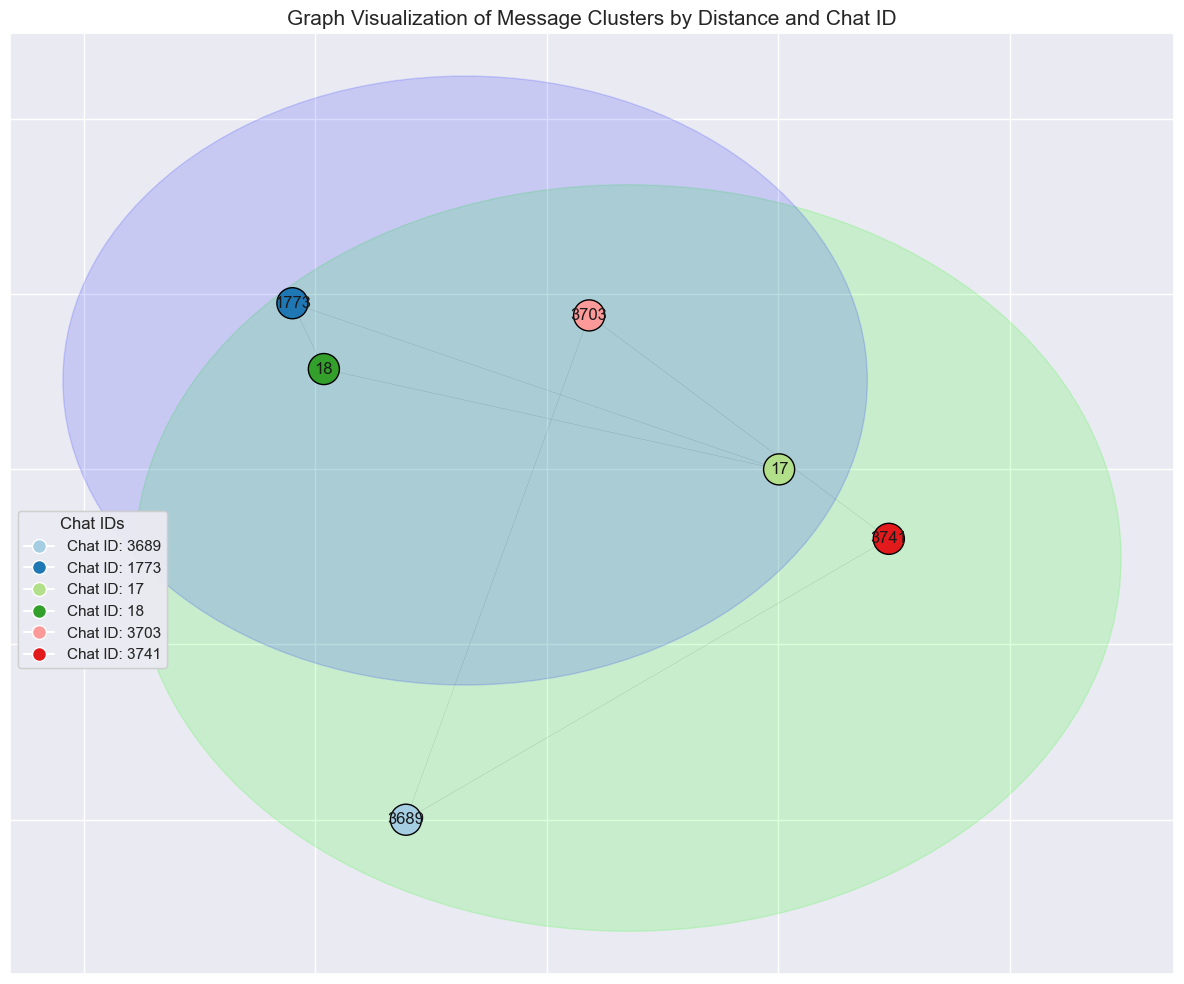

In [1090]:
# count values of c_id
clusters_compare_df['c_id'].value_counts()
# get the list of c_id with more than 1 value and less than 10
flt = (clusters_compare_df['c_id'].value_counts() > 1) & (clusters_compare_df['c_id'].value_counts() < 5)
# flt =  (clusters_compare_df['c_id'].value_counts() < 3)
sub_grp = clusters_compare_df['c_id'].value_counts()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
test_clusters = clusters_compare_df[flt]
plot_clusters(test_clusters, 0.0001)

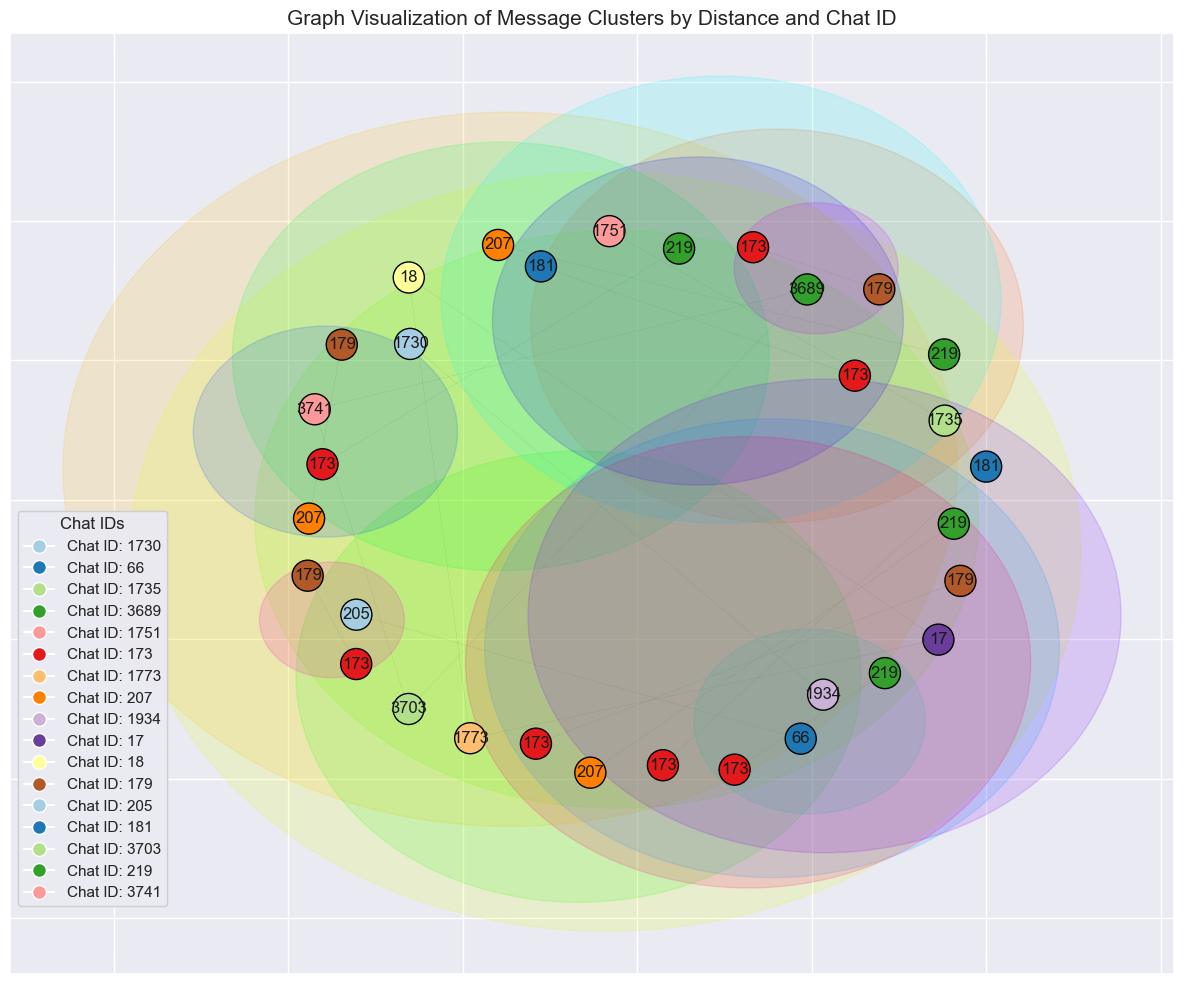

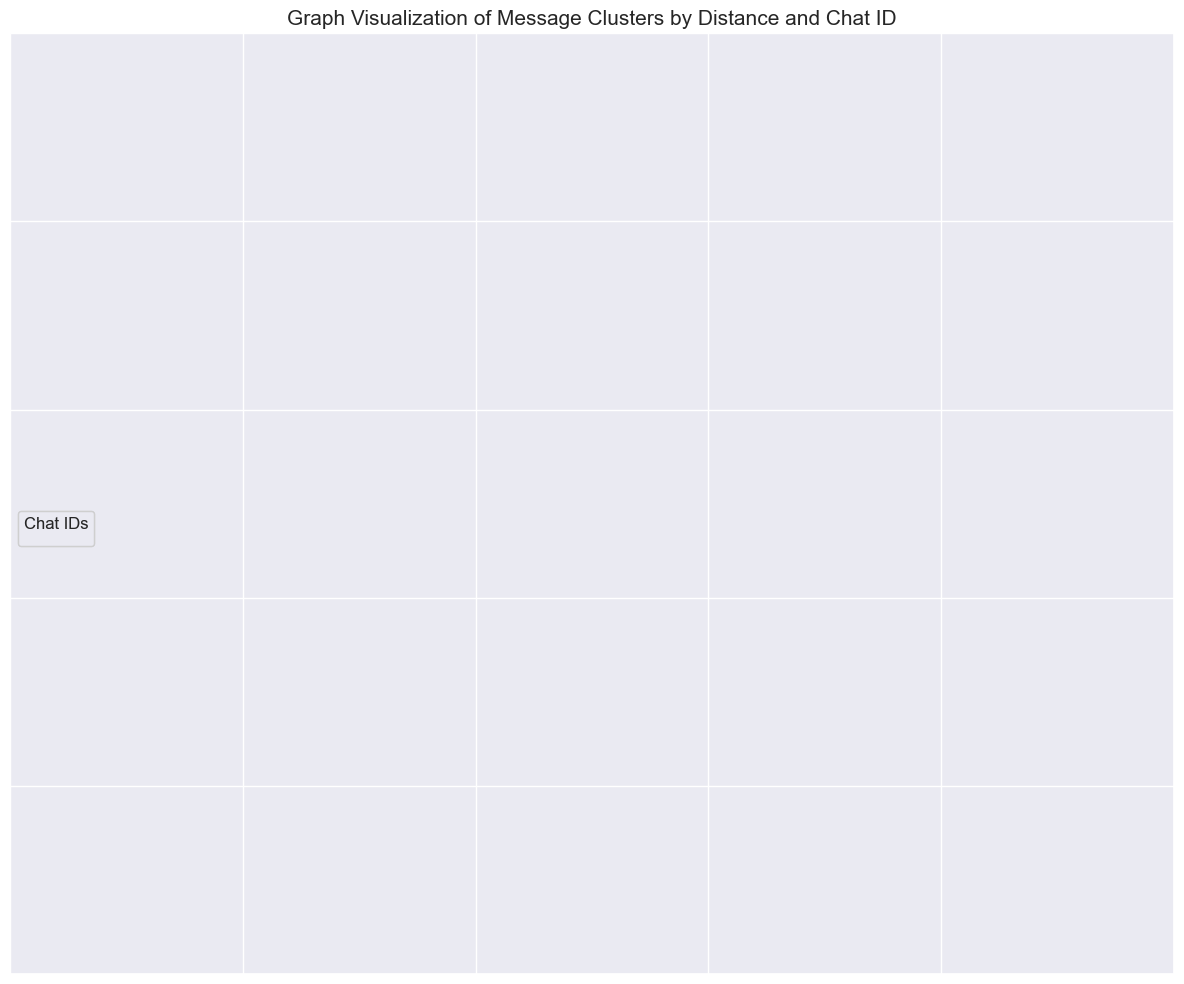

In [1061]:
# count values of c_id
clusters_compare_df['c_id'].value_counts()
# get the list of c_id with more than 1 value and less than 10
flt = (clusters_compare_df['c_id'].value_counts() > 20) & (clusters_compare_df['c_id'].value_counts() < 30)
sub_grp = clusters_compare_df['c_id'].value_counts()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
test_clusters = clusters_compare_df[flt]
plot_clusters(test_clusters, 0.5)

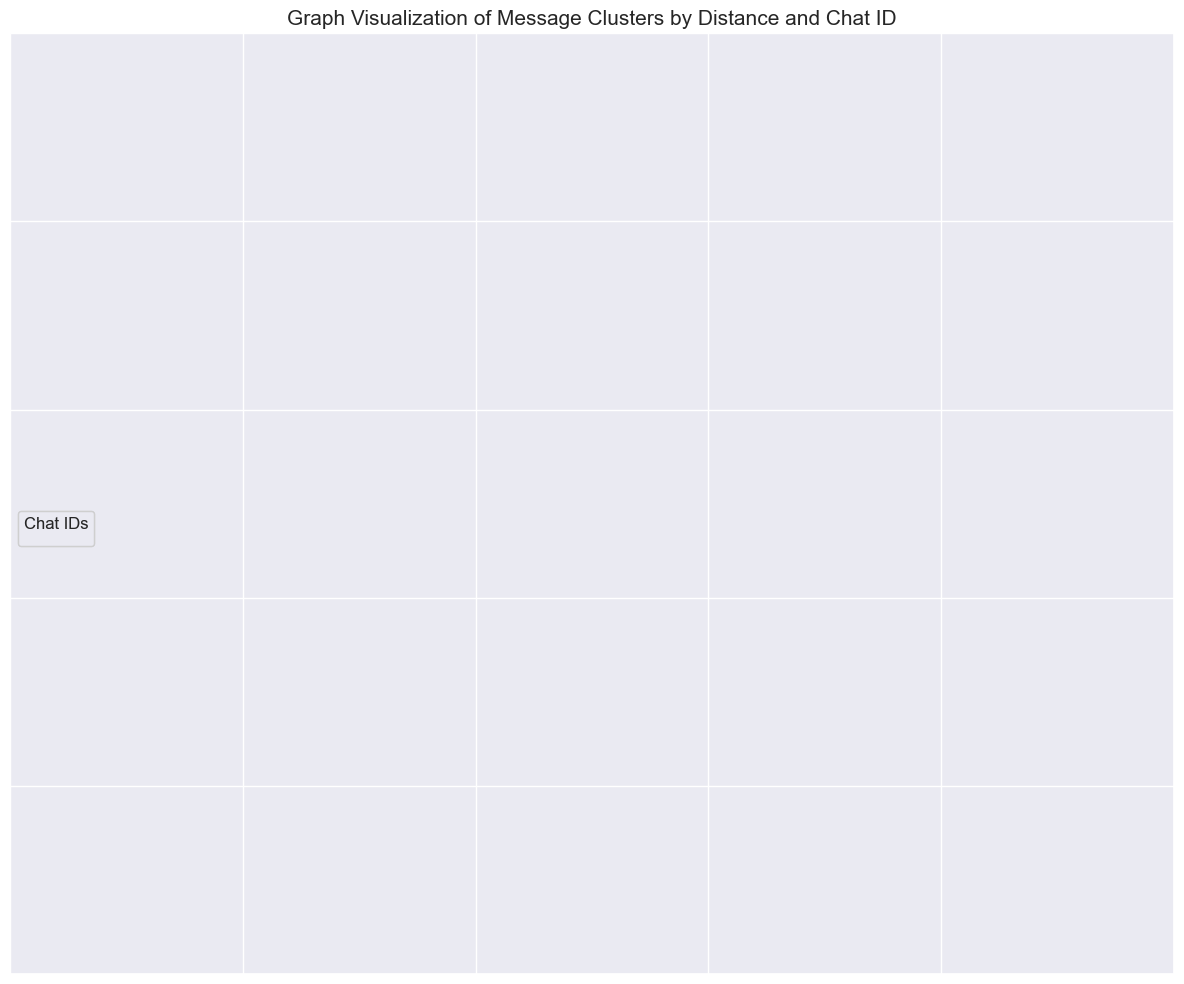

In [1062]:
# count values of c_id
clusters_compare_df['c_id'].value_counts()
# get the list of c_id with more than 1 value and less than 10
flt = (clusters_compare_df['c_id'].value_counts() > 30) & (clusters_compare_df['c_id'].value_counts() < 50)
sub_grp = clusters_compare_df['c_id'].value_counts()[flt].head(15)

# filter clusters_compare_df by c_id in sub_grp
flt = clusters_compare_df['c_id'].isin(sub_grp.index)
test_clusters = clusters_compare_df[flt]


plot_clusters(test_clusters, 0.35)

In [1063]:
clusters_compare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   c_id                       59 non-null     object             
 1   c_grp                      59 non-null     int64              
 2   sc_id                      59 non-null     int64              
 3   id_1                       59 non-null     int64              
 4   id_2                       59 non-null     int64              
 5   similarity                 59 non-null     float64            
 6   message_text_clean_utf8_1  59 non-null     object             
 7   cleaned_sim_1              59 non-null     object             
 8   chat_id_1                  59 non-null     int64              
 9   date_id_1                  59 non-null     datetime64[ns, UTC]
 10  message_text_clean_utf8_2  59 non-null     object             
 11  cleaned_

In [1064]:
import pandas as pd

def channel_corr_metrics(df_comp_cluster):
    # filter df_comp where chat_id_1 == chat_id_2
    flt = df_comp_cluster['chat_id_1'] != df_comp_cluster['chat_id_2']
    df_comp_cluster = df_comp_cluster[flt].copy()

    # add a column id_low with the lower id between chat_id_1 and chat_id_2
    df_comp_cluster['id_low'] = df_comp_cluster.apply(lambda x: min(x['chat_id_1'], x['chat_id_2']), axis=1)
    # add a column id_low with the max id between chat_id_1 and chat_id_2
    df_comp_cluster['id_high'] = df_comp_cluster.apply(lambda x: max(x['chat_id_1'], x['chat_id_2']), axis=1)

    # get the number of messages group by id_low and id_high, also average and meadian distance and similarity and number of clusters(c_id)
    chats_data = df_comp_cluster.groupby(['id_low', 'id_high']).agg({
        # 'distance': ['mean', 'median', 'min', 'max'],
        'similarity': ['mean', 'median', 'min', 'max', 'sum'],
        'c_id': 'nunique',
        'id_1': 'count'
    }).reset_index()

    # rename the columns
    chats_data.columns = ['id_low', 'id_high',
                        # 'avg_distance', 'median_distance', 'min_distance', 'max_distance',
                          'avg_sim', 'median_sim', 'min_sim', 'max_sim', 'sum_sim', 
                          'num_clusters', 'num_messages']


    # group by id_low, id_high and c_id, get the avg and median of similarity and distance, also number of items
    cluster_data = df_comp_cluster.groupby(['id_low', 'id_high', 'c_id']).agg({
        # 'distance': ['mean', 'median'],
        'similarity': ['mean', 'median'],
        'c_id': 'count'
    }).reset_index()

    # rename the columns
    cluster_data.columns = ['id_low', 'id_high', 'c_id', 
                            'avg_sim', 'median_sim',
                            'cluster_size']

    
    # group cluster_data by id_low and id_high and get the avg and median of the cluster_size
    cluster_size_data = cluster_data.groupby(['id_low', 'id_high']).agg({
        'cluster_size': ['mean', 'median'],
        'avg_sim': ['mean'],
        'median_sim': ['mean'],
    }).reset_index()

    # rename the columns

    cluster_size_data.columns = ['id_low', 'id_high', 
                                 'avg_cluster_size', 'median_cluster_size', 
                                 'avg_cl_avg_sim', 'avg_cl_median_sim']

    # merge chats_data with cluster_size_data
    channel_corr_data = pd.merge(chats_data, cluster_size_data, on=['id_low', 'id_high'], how='left')

    # sort by num_messages
    channel_corr_data = channel_corr_data.sort_values(by='num_messages', ascending=False)
    
    return channel_corr_data
    # return chats_data


# Example usage with the given df_comp DataFrame
channel_correlation_data = channel_corr_metrics(clusters_compare_df)

channel_correlation_data = channel_correlation_data.sort_values(by='num_messages', ascending=False)
channel_correlation_data.head(30).tail(20)


,id_low,id_high,avg_sim,median_sim,min_sim,max_sim,sum_sim,num_clusters,num_messages,avg_cluster_size,median_cluster_size,avg_cl_avg_sim,avg_cl_median_sim
14,1735,1751,1.0,1.0,1.0,1.0,10.0,10,10,1.0,1.0,1.0,1.0
7,173,179,1.0,1.0,1.0,1.0,5.0,5,5,1.0,1.0,1.0,1.0
6,114,173,1.0,1.0,1.0,1.0,4.0,4,4,1.0,1.0,1.0,1.0
8,173,181,1.0,1.0,1.0,1.0,4.0,4,4,1.0,1.0,1.0,1.0
9,173,219,1.0,1.0,1.0,1.0,3.0,3,3,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,2633,2671,1.0,1.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
18,3689,3703,1.0,1.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
19,3689,3741,1.0,1.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
16,2099,2133,1.0,1.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0


In [1065]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   message_lbr                89 non-null     int64              
 1   word_bin                   89 non-null     int64              
 2   trade_type                 89 non-null     object             
 3   id_1                       89 non-null     int64              
 4   id_2                       89 non-null     int64              
 5   similarity                 89 non-null     float64            
 6   message_text_clean_utf8_1  89 non-null     object             
 7   cleaned_sim_1              89 non-null     object             
 8   chat_id_1                  89 non-null     int64              
 9   date_id_1                  89 non-null     datetime64[ns, UTC]
 10  message_text_clean_utf8_2  89 non-null     object             
 11  cleaned_

In [1066]:
#filter df_comp by chat_id_1 == chat_id_a and chat_id_2 == chat_id_b and viceversa
chat_id_a, chat_id_b = 179, 219
# chat_id_a, chat_id_b = 11921, 10405

flt = (df_comp['chat_id_1'] == chat_id_a) & (df_comp['chat_id_2'] == chat_id_b)
flt = flt | ((df_comp['chat_id_1'] == chat_id_b) & (df_comp['chat_id_2'] == chat_id_a))

df_comp[flt]

,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance


In [1067]:
# id_a, id_b = 11921, 10405 # 11921, 10405, 4042  - Missing
# id_a, id_b = 11921, 4042 # 11921, 10405, 4042 - Missing
id_a, id_b = 4042, 10405 # 11921, 10405, 4042 - OK in df_comp - fechas ok


flt =        (df_comp['id_1'] == id_a) & (df_comp['id_2'] == id_b)
flt = flt | ((df_comp['id_1'] == id_b) & (df_comp['id_2'] == id_a))

df_comp[flt]

,message_lbr,word_bin,trade_type,id_1,id_2,similarity,message_text_clean_utf8_1,cleaned_sim_1,chat_id_1,date_id_1,message_text_clean_utf8_2,cleaned_sim_2,chat_id_2,date_id_2,distance
21,12,29,buy,4042,10405,1.0,maskusdt\nlong\nentry: 1.045-1.01365\nleverage...,maskusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,173,2022-10-23 17:20:27+00:00,maskusdt\nlong\nentry: 1.045-1.01365\nleverage...,maskusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,114,2022-10-23 18:35:11+00:00,0.0


In [1068]:
flt = df_sim['id_msg'] == 11921
df_sim[flt]

,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg,...,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words_utf8,message_lbr_utf8,cleaned_sim,message_words,message_lbr,word_bin
11064,12643,2022-10-16 13:07:21+00,DASHUSDT\nLONG\nEntry: 41.38-40.1386\nLeverage...,DASH,buy,binancekillerstrades,Binance Killers®,181,es,11921,...,dashusdt\nlong\nentry: 41.38-40.1386\nleverage...,ascii,dashusdt\nlong\nentry: 41.38-40.1386\nleverage...,225,42,12,dashusdt\nlong\nentry {NUM} {NUM} {NUM} {NUM}\...,37,12,29


In [1069]:
# flatten clusters_affinity_propagation
clusters_affinity_propagation_flat = list(chain.from_iterable(list(chain.from_iterable(clusters_affinity_propagation))))

clusters_affinity_propagation_flat
# check id_a and id_b in clusters_affinity_propagation_flat
id_a in clusters_affinity_propagation_flat
id_b in clusters_affinity_propagation_flat



True

In [1070]:
check_sim_chats(clusters_compare_df, 179,219, width=50)

In [1071]:
check_sim_chats(clusters_compare_df, 181, 207, width=50)

In [1072]:
# get the unique values of chat_id aand title
chat_id_title = df[['chat_id', 'telegram_user_id', 'title']].drop_duplicates()

# filter chat_id_title by chat_id in channel_correlation_data['id_low'] and channel_correlation_data['id_high']
flt = chat_id_title['chat_id'].isin(channel_correlation_data['id_low']) | chat_id_title['chat_id'].isin(channel_correlation_data['id_high'])
chat_id_title = chat_id_title[flt]

# filter by chat id in [1,3]
flt = chat_id_title['chat_id'].isin([173, 207, 219, 101, 1735, 1751])
chat_id_title[flt]

,chat_id,telegram_user_id,title
9892,173,Bitstamp_1,BITSTAMP SIGNALS ®️
11608,207,NaN,Cryptotegic™
11815,219,Zignaly00,Zignaly Crypto Signals ®
11988,1735,bigpumpsignals_official,Big pump signals
12046,1751,crypto_pump_lsland,Crypto pump island backup 1


In [1073]:
# check_sim_chats(clusters_compare_df, 1773, 18)
check_sim_chats(clusters_compare_df, 79, 2172)

# filter df where message contains 'AffinityPropagation'
# flt = df['message_text'].str.contains('0.12400-0.12100')
flt = df['chat_id'] == 79
# also filter by 
# flt = flt & (df['message_text'].str.contains('10.8108'))
flt = flt & (df['message_text'].str.contains('𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖'))

df[flt].head(10)



,signal_id,source_posted_at,message_text,commodity,trade_type,telegram_user_id,title,chat_id,language,id_msg,...,message_text_clean,message_encoding,message_text_clean_utf8,message_length,message_words,message_lbr,time_diff,duplicates,duplicate_count,duplicates_near
3702,58723,2022-03-18 03:28:55+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. 1INCHUSDT .◦°˚°◦...,1INCH,buy,Scalping_300,Scalping_300%,79,es,9922,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. 1inchusdt .◦°˚°◦...,Windows-1254,SCALPING 300 ]\n*deg@deg*. 1inchusdt .*deg@deg...,335,64,16,NaT,False,1,False
3727,54303,2022-03-21 05:26:37+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. AAVEUSDT .◦°˚°◦✬...,AAVE,buy,Scalping_300,Scalping_300%,79,es,9447,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. aaveusdt .◦°˚°◦✬...,Windows-1254,SCALPING 300 ]\n*deg@deg*. aaveusdt .*deg@deg*...,336,64,16,NaT,False,1,False
3706,32696,2022-03-18 14:28:13+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. ADAUSDT .◦°˚°◦✬\...,ADA,buy,Scalping_300,Scalping_300%,79,es,12779,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. adausdt .◦°˚°◦✬\...,Windows-1254,SCALPING 300 ]\n*deg@deg*. adausdt .*deg@deg*\...,338,64,16,NaT,False,1,False
3722,38626,2022-03-20 12:21:51+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. ADAUSDT .◦°˚°◦✬\...,ADA,buy,Scalping_300,Scalping_300%,79,es,3466,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. adausdt .◦°˚°◦✬\...,Windows-1254,SCALPING 300 ]\n*deg@deg*. adausdt .*deg@deg*\...,334,64,16,NaT,False,1,False
3716,53999,2022-03-20 02:00:15+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. ALGOUSDT .◦°˚°◦✬...,ALGO,buy,Scalping_300,Scalping_300%,79,es,1421,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. algousdt .◦°˚°◦✬...,Windows-1254,SCALPING 300 ]\n*deg@deg*. algousdt .*deg@deg*...,345,64,16,NaT,False,1,False
3699,38474,2022-03-18 03:28:47+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. ALPHAUSDT .◦°˚°◦...,ALPHA,buy,Scalping_300,Scalping_300%,79,es,2684,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. alphausdt .◦°˚°◦...,Windows-1254,SCALPING 300 ]\n*deg@deg*. alphausdt .*deg@deg...,346,64,16,NaT,False,1,False
3731,33542,2022-03-22 02:05:52+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. ALPHAUSDT .◦°˚°◦...,ALPHA,buy,Scalping_300,Scalping_300%,79,es,7932,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. alphausdt .◦°˚°◦...,Windows-1254,SCALPING 300 ]\n*deg@deg*. alphausdt .*deg@deg...,345,64,16,NaT,False,1,False
3710,54244,2022-03-18 15:30:28+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. AUDIOUSDT .◦°˚°◦...,AUDIO,buy,Scalping_300,Scalping_300%,79,es,9442,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. audiousdt .◦°˚°◦...,Windows-1254,SCALPING 300 ]\n*deg@deg*. audiousdt .*deg@deg...,338,64,16,NaT,False,1,False
3705,58728,2022-03-18 14:28:13+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. AVAXUSDT .◦°˚°◦✬...,AVAX,buy,Scalping_300,Scalping_300%,79,es,9223,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. avaxusdt .◦°˚°◦✬...,Windows-1254,SCALPING 300 ]\n*deg@deg*. avaxusdt .*deg@deg*...,332,64,16,NaT,False,1,False
3721,33529,2022-03-20 12:21:51+00,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. AXSUSDT .◦°˚°◦✬\...,AXS,buy,Scalping_300,Scalping_300%,79,es,901,...,꧁༺ 𝓢𝓒𝓐𝓛𝓟𝓘𝓝𝓖 300 ༻꧂\n\n✬◦°˚°◦. axsusdt .◦°˚°◦✬\...,Windows-1254,SCALPING 300 ]\n*deg@deg*. axsusdt .*deg@deg*\...,334,64,16,NaT,False,1,False
